# **Environment Setup**

In [ ]:
# --- Imports ---
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import brevitas.nn as qnn
from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerChannelFloat, Uint8ActPerTensorFloat

In [3]:
# --- Globals ---

# Valid labels for raw input (before AAMI conversion)

AAMI_CLASSES = {
    'N': ['N', '·', 'L', 'R', 'e', 'j'],
    'S': ['A', 'a', 'J', 'S'],
    'V': ['V', 'E'],
    'F': ['F']
}

# Generate AAMI_MAP from AAMI_CLASSES
AAMI_MAP = {}
for aami_label, raw_list in AAMI_CLASSES.items():
    for raw_label in raw_list:
        AAMI_MAP[raw_label] = aami_label

#AAMI_HIERARCHY_ORDER_FOR_LABELS = ['V', 'F', 'S', 'Q', 'N'] # This is the order that determined the integer labels
#AAMI_CLASS_NAMES = AAMI_HIERARCHY_ORDER_FOR_LABELS

AAMI_CLASS_NAMES = list(AAMI_CLASSES.keys())  # ['N', 'S', 'V', 'F']



save_dir = '/home/eveneiha/finn/workspace/ml/data/preprocessed/inter_patient/'


def add_center_region_mask(x, center_idx=500, width=100):
    mask = torch.zeros_like(x)
    start = max(center_idx - width, 0)
    end = min(center_idx + width + 1, x.shape[1])
    mask[:, start:end, :] = 1.0

    return torch.cat([x, mask], dim=0)  # (2, T, 1)

class PreprocessedECGDataset(Dataset):
    def __init__(self, inputs, labels):#, win_ids):
        self.inputs = inputs
        self.labels = labels
        #self.win_ids = win_ids

    def __len__(self):
        return self.inputs.size(0)

    # def __getitem__(self, idx):
    #     x = self.inputs[idx]  # shape: (1, T, 1)
    #     label = self.labels[idx]

    #     # Add binary mask channel (centered at middle of input)
    #     center_idx = x.shape[1] // 2
    #     x_with_mask = add_center_region_mask(x, center_idx=center_idx, width=70)

    #     return x_with_mask, label
    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]#, self.win_ids[idx]

## **Load Train, Val, Test**

In [4]:
# # --- Split train/val/test from .pt-files ---


train_data = torch.load(os.path.join(save_dir, "train.pt"))
train_inputs = train_data["inputs"]
train_labels = train_data["labels"]
#train_ids = train_data["window_ids"]

val_data = torch.load(os.path.join(save_dir, "val.pt"))
val_inputs = val_data["inputs"]
val_labels = val_data["labels"]
#val_ids = val_data["window_ids"]

test_data = torch.load(os.path.join(save_dir, "test.pt"))
test_inputs = test_data["inputs"]
test_labels = test_data["labels"]
#test_ids = test_data["window_ids"]



train_dataset = PreprocessedECGDataset(train_inputs, train_labels)#, train_ids)
val_dataset   = PreprocessedECGDataset(val_inputs, val_labels)#, val_ids)
test_dataset  = PreprocessedECGDataset(test_inputs, test_labels)#, test_ids)



batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


test_inputs_numpy = test_inputs.numpy()
test_labels_numpy = test_labels.numpy()

# Save the data to .npy files
np.save('/home/eveneiha/finn/workspace/ml/data/input.npy', test_inputs_numpy)
np.save('/home/eveneiha/finn/workspace/ml/data/labels.npy', test_labels_numpy)

print("Test data saved to .npy files.")



/tmp/ipykernel_2524317/2866150754.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(save_dir, "train.pt"))
/tmp/ipykernel_2524317/2866

Test data saved to .npy files.



Plotting random window (Raw Label):
Filtering for labels [0]... (can be slow on large datasets)
Found 31450 samples matching filter.


/tmp/ipykernel_2524317/976932819.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(save_dir, "train.pt"))


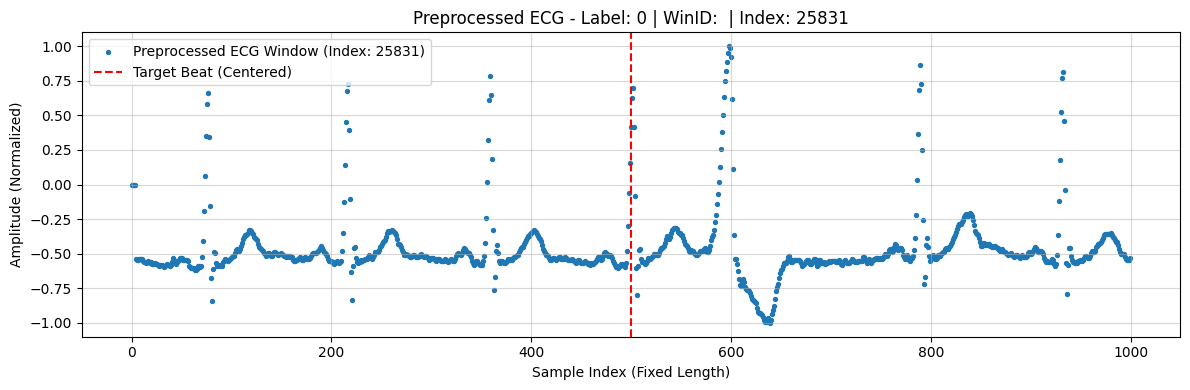


Plotting random window (AAMI Label):
Filtering for labels [1]... (can be slow on large datasets)
Found 656 samples matching filter.


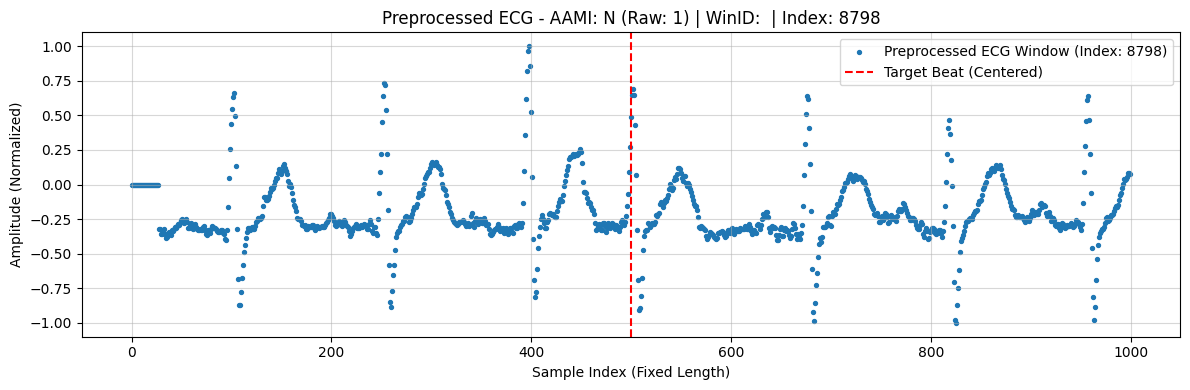


Plotting random window with Label 2 (AAMI Label):
Filtering for labels [2]... (can be slow on large datasets)
Found 2617 samples matching filter.


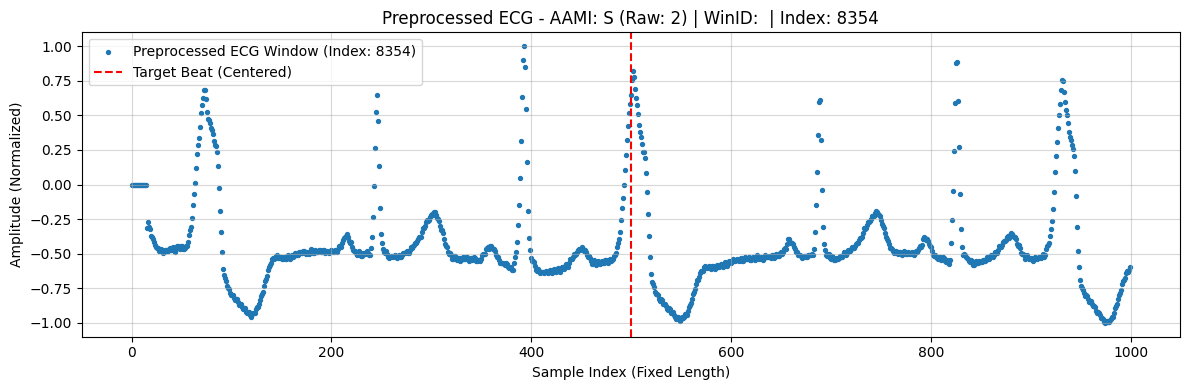


Plotting random window with Label 1 or 2 (Raw Label):
Filtering for labels [3]... (can be slow on large datasets)
Found 288 samples matching filter.


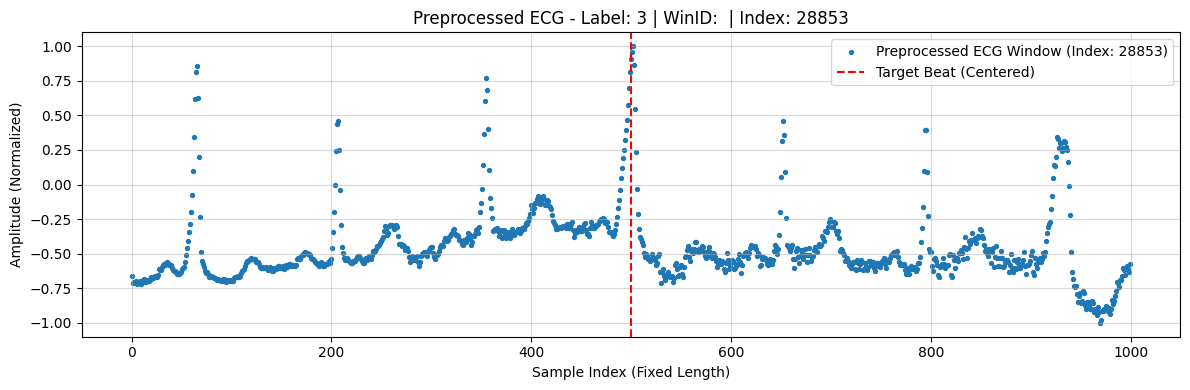

Filtering for labels [4]... (can be slow on large datasets)
No samples found with label(s): [4]


In [5]:
# --- Plotting of inputs for visualization ---

AAMI_MAP = {
    1: 'N',    # Normal beat
    2: 'S',    # Supraventricular ectopic beat (SVEB)
    3: 'V',    # Ventricular ectopic beat (VEB)
    4: 'F',    # Fusion beat
   # 5: 'Q',    # Unknown beat / Unclassifiable
}


def plot_random_preprocessed_window(data_source, label_filter=None, title_label='raw', figsize=(12, 4)):

    assert title_label in ['raw', 'aami'], "title_label must be 'raw' or 'aami'"
    if title_label == 'aami' and 'AAMI_MAP' not in globals():
        print("⚠️ Warning: title_label='aami' requires AAMI_MAP to be defined globally.")
        print("Falling back to title_label='raw'.")
        title_label = 'raw'

    possible_indices = list(range(len(data_source)))

    # --- Filter indices based on label_filter if provided ---
    if label_filter is not None:
        if isinstance(label_filter, int):
            label_filter = [label_filter] # Ensure it's a list

        filtered_indices = []
        print(f"Filtering for labels {label_filter}... (can be slow on large datasets)")
        # Iterate through indices and check labels efficiently
        all_labels = data_source.labels # Access the full labels tensor directly
        for i in possible_indices:
             # Check if the label at index i is in the filter list
             if all_labels[i].item() in label_filter:
                 filtered_indices.append(i)

        if not filtered_indices:
            print(f"No samples found with label(s): {label_filter}")
            return
        possible_indices = filtered_indices
        print(f"Found {len(possible_indices)} samples matching filter.")

    # --- Select a random sample ---
    if not possible_indices:
        print("No samples available in the dataset.")
        return
    random_idx = random.choice(possible_indices)
    ecg_tensor, label_tensor = data_source[random_idx]

    # --- Data Extraction and Preparation ---
    # Ensure tensor is on CPU and convert to numpy
    ecg_np = ecg_tensor.squeeze().cpu().numpy()
    label = label_tensor.item() # Get scalar label value
    # Handle window_id if it's a tensor or scalar
    # if torch.is_tensor(window_id_tensor) and window_id_tensor.numel() == 1:
    #      window_id = window_id_tensor.item()
    # else:
    #      window_id = window_id_tensor # Keep as is if it's already a number or list/etc.


    # Handle potential multi-channel data (plot the first channel)
    if ecg_np.ndim > 1:
        print(f"Input tensor has {ecg_np.shape} shape. Plotting channel 0.")
        ecg_np = ecg_np[0, :] # Select first channel

    fixed_len = ecg_np.shape[0]
    # The preprocessing is assumed to place the target beat at the center
    center_pos = fixed_len // 2

    # --- Plotting ---
    # Choose title based on label mapping
    if title_label == 'aami':
        aami_label_str = AAMI_MAP.get(label, f'Unknown ({label})') # Use get for safety
        title = f"Preprocessed ECG - AAMI: {aami_label_str} (Raw: {label}) | WinID:  | Index: {random_idx}"
    else: # 'raw'
        title = f"Preprocessed ECG - Label: {label} | WinID:  | Index: {random_idx}"

    plt.figure(figsize=figsize)
    #plt.plot(ecg_np, label=f"Preprocessed ECG Window (Index: {random_idx})")
    plt.scatter(range(len(ecg_np)), ecg_np, s=8, label=f"Preprocessed ECG Window (Index: {random_idx})")

    # Mark the assumed center (target beat position)
    # Note: We cannot mark other beats as their processed positions are unknown
    plt.axvline(x=center_pos, color='r', linestyle='--', linewidth=1.5, label="Target Beat (Centered)")

    plt.title(title)
    plt.xlabel("Sample Index (Fixed Length)")
    plt.ylabel("Amplitude (Normalized)") # Assuming data is normalized
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()


# 1. Load your data (replace with your actual loading)
try:
    train_data = torch.load(os.path.join(save_dir, "train.pt"))
    train_inputs = train_data["inputs"]
    train_labels = train_data["labels"]
    #train_ids = train_data["window_ids"]

    # 2. Create Dataset instances
    train_dataset = PreprocessedECGDataset(train_inputs, train_labels)

    # 3. Call the plotting function
    print("\nPlotting random window (Raw Label):")
    plot_random_preprocessed_window(train_dataset, label_filter=0, title_label='raw')

    print("\nPlotting random window (AAMI Label):")
    plot_random_preprocessed_window(train_dataset, label_filter=1, title_label='aami')

    # Example with label filter (e.g., plot only class 2 - 'V' if using AAMI_MAP above)
    print("\nPlotting random window with Label 2 (AAMI Label):")
    plot_random_preprocessed_window(train_dataset, label_filter=2, title_label='aami')

    # Example with multiple label filter
    print("\nPlotting random window with Label 1 or 2 (Raw Label):")
    plot_random_preprocessed_window(train_dataset, label_filter=3, title_label='raw')
    plot_random_preprocessed_window(train_dataset, label_filter=4, title_label='raw')

except FileNotFoundError:
    print(f"Error: Data files not found in {save_dir}. Please check the path.")
except KeyError as e:
    print(f"Error: Missing key {e} in loaded .pt file. Ensure files contain 'inputs', 'labels', 'window_ids'.")

# sample, _ = train_dataset[0]
# ecg, mask = sample[0, :, 0], sample[1, :, 0]

# plt.plot(ecg, label="ECG")
# plt.plot(mask, label="Mask", linestyle='--')
# plt.legend()
# plt.title("ECG + Center Mask")
# plt.show()

# **TCN ORIGINAL**

In [ ]:
# --- Main TCN Architecture ---


from brevitas.core.scaling import ConstScaling

def calculate_receptive_field(layers):
    """
    Compute the receptive field given a sequence of convolution layers.

    Parameters:
      layers (list of dict): Each dictionary should contain:
          - 'kernel_size': The size of the kernel (int)
          - 'dilation': The dilation factor (int; default 1 if not provided)
          - 'stride': The stride used (int; default 1 if not provided)

    Returns:
      int: The overall receptive field (number of input time steps covered by the central output)
    """
    receptive_field = 1  # start with a single input point
    jump = 1             # initial jump (distance between successive receptive field centers)

    for i, layer in enumerate(layers):
        ks = layer['kernel_size']
        dilation = layer.get('dilation', 1)
        stride = layer.get('stride', 1)
        # Calculate effective kernel size for this layer:
        effective_kernel_size = (ks - 1) * dilation + 1

        # Update receptive field
        receptive_field += (effective_kernel_size - 1) * jump

        # Update jump (effective stride from the input perspective)
        jump *= stride

        # Optional: print intermediate values for debugging/understanding
        print(f"Layer {i+1}: kernel_size={ks}, dilation={dilation}, stride={stride}, "
              f"effective_kernel_size={effective_kernel_size}, jump={jump}, "
              f"receptive_field={receptive_field}")

    return receptive_field
 

class TemporalBlock2d(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, dilation, stride, dropout=0.2, not_first = False):
        super(TemporalBlock2d, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.stride = stride
        self.conv_quant = Int8ActPerTensorFloat
        if not_first:
            self.conv_quant = None
                
        self.conv1 = qnn.QuantConv2d(
            n_inputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(stride, 1),
            padding=(0, 0),  # no padding – only compute valid outputs
            dilation=(dilation, 1),
            weight_quant=Int8WeightPerChannelFloat,
            input_quant= self.conv_quant,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False,
        )
        
        
        self.bn1 = nn.BatchNorm2d(n_outputs)
        self.dropout1 = nn.Dropout(dropout)
   
        self.conv2 = qnn.QuantConv2d(
            n_outputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(1, 1),
            padding=(0, 0),
            dilation=(dilation, 1),
            weight_quant=Int8WeightPerChannelFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False,
        )       
        
        self.bn2 = nn.BatchNorm2d(n_outputs)
        self.dropout2 = nn.Dropout(dropout)
        self.relu = qnn.QuantReLU(
            act_quant=Uint8ActPerTensorFloat,   
            output_quant=Int8ActPerTensorFloat, 
            act_bit_width=8,
            output_bit_width=8,
            return_quant_tensor=False
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        return x


class TCN2d(nn.Module):
    def __init__(self, custom_blocks: list, num_outputs: int):
        super(TCN2d, self).__init__()
        self.temporal_blocks = nn.ModuleList(custom_blocks)
        last_out_channels = custom_blocks[-1].conv2.out_channels
                 
        # We also need a 1x1 conv to get to num_outputs
        self.fc = qnn.QuantConv2d(
            in_channels=last_out_channels,
            out_channels=num_outputs,
            kernel_size=(1, 1),
            weight_quant=Int8WeightPerChannelFloat,
            input_quant=None,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False,
        )


    def forward(self, x): # Input is float
        for block in self.temporal_blocks:
            x = block(x) 
        x = self.fc(x) # Output likely INT32 internal or QuantTensor
        x = x.value if hasattr(x, 'value') else x      
        
        ## consider adding a softmax layer here 
        x = x.value if hasattr(x, 'value') else x
        x_reshaped = x.reshape(x.size(0), -1)
        return x_reshaped
    
block1 = TemporalBlock2d(1, 4, kernel_size=9, dilation=1,  stride=2,  dropout=0.036)
block2 = TemporalBlock2d(4, 8, kernel_size=9, dilation=4,  stride=1,  dropout=0.036, not_first=True) # 0.036
block3 = TemporalBlock2d(8, 16, kernel_size=9, dilation=16,  stride=1,  dropout=0, not_first=True) # 0.05

custom_blocks = [block1, block2, block3]

layers = [
    {'kernel_size': 9, 'dilation': 1,  'stride': 2},  # Block 1 - Conv1
    {'kernel_size': 9, 'dilation': 1,  'stride': 1},  # Block 1 - Conv2
    {'kernel_size': 9, 'dilation': 4,  'stride': 1},  # Block 2 - Conv1
    {'kernel_size': 9, 'dilation': 4,  'stride': 1},  # Block 2 - Conv2
    {'kernel_size': 9, 'dilation': 16, 'stride': 1},  # Block 3 - Conv1
    {'kernel_size': 9, 'dilation': 16, 'stride': 1},  # Block 3 - Conv2
]

rf = calculate_receptive_field(layers)
print(f"\nFinal receptive field: {rf} input time steps")


Layer 1: kernel_size=9, dilation=1, stride=2, effective_kernel_size=9, jump=2, receptive_field=9
Layer 2: kernel_size=9, dilation=1, stride=1, effective_kernel_size=9, jump=2, receptive_field=25
Layer 3: kernel_size=9, dilation=4, stride=1, effective_kernel_size=33, jump=2, receptive_field=89
Layer 4: kernel_size=9, dilation=4, stride=1, effective_kernel_size=33, jump=2, receptive_field=153
Layer 5: kernel_size=9, dilation=16, stride=1, effective_kernel_size=129, jump=2, receptive_field=409
Layer 6: kernel_size=9, dilation=16, stride=1, effective_kernel_size=129, jump=2, receptive_field=665

Final receptive field: 665 input time steps


## OPTUNA CONFIG


In [6]:
# import optuna
# from sklearn.metrics import f1_score
# from optuna.exceptions import TrialPruned
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class_counts = torch.tensor([
#     61971,  # Class 0 (N)
#     1933,   # Class 1 (S)
#     4858,   # Class 2 (V)
#     561     # Class 3 (F)
# ])

# class NonUniformLabelSmoothingLoss(nn.Module):
#     def __init__(self, class_counts, smoothing=0.1, reduction='mean'):
#         super().__init__()
#         self.smoothing = smoothing
#         self.reduction = reduction

#         class_weights = 1.0 / (class_counts.float()**1.5)
#         class_weights = class_weights / class_weights.sum()
#         self.register_buffer("class_weights", class_weights)

#     def forward(self, logits, target):
#         with torch.no_grad():
#             true_dist = self.class_weights.unsqueeze(0).repeat(target.size(0), 1)
#             true_dist = true_dist * self.smoothing
#             true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)

#         log_probs = F.log_softmax(logits, dim=1)
#         loss = -(true_dist * log_probs).sum(dim=1)

#         if self.reduction == 'mean':
#             return loss.mean()
#         elif self.reduction == 'sum':
#             return loss.sum()
#         else:
#             return loss

# def objective(trial):
#     lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
#     dropout = trial.suggest_float("dropout", 0.0, 0.4)
#     smoothing = trial.suggest_float("smoothing", 0.0, 0.2)

#     blocks = [
#         TemporalBlock2d(1, 4, 9, 1, 2, dropout),
#         TemporalBlock2d(4, 8, 9, 4, 1, dropout),
#         TemporalBlock2d(8, 16, 9, 16, 1, dropout),
#     ]
#     model = TCN2d(custom_blocks=blocks, num_outputs=4).to(device)

#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2)
#     criterion = NonUniformLabelSmoothingLoss(class_counts=class_counts, smoothing=smoothing)

#     best_f1 = 0.0
#     num_epochs = 15

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         batch_count = 0

#         for xb, yb in train_dataloader:
#             xb, yb = xb.to(device), yb.to(device)
#             optimizer.zero_grad()
#             outputs = model(xb)
#             loss = criterion(outputs, yb)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#             batch_count += 1

#         train_loss = running_loss / batch_count
#         scheduler.step(train_loss)

#         # --- Validation ---
#         model.eval()
#         all_preds, all_targets = [], []
#         with torch.no_grad():
#             for xb, yb in val_dataloader:
#                 xb, yb = xb.to(device), yb.to(device)
#                 outputs = model(xb)
#                 preds = outputs.argmax(dim=1).cpu().numpy()
#                 all_preds.extend(preds)
#                 all_targets.extend(yb.cpu().numpy())

#         f1 = f1_score(all_targets, all_preds, average='macro')
#         print(f"[Trial {trial.number}] Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Macro F1: {f1:.4f}")

#         # Optuna reporting and pruning
#         trial.report(-f1, step=epoch)
#         if trial.should_prune():
#             raise TrialPruned()

#         best_f1 = max(best_f1, f1)

#     return -best_f1

# # Use MedianPruner to stop underperforming trials early
# pruner = optuna.pruners.MedianPruner(n_warmup_steps=3)
# study = optuna.create_study(direction="minimize", pruner=pruner)
# study.optimize(objective, n_trials=30)

# # Print best result
# best_trial = study.best_trial
# print(f"\nBest Macro F1: {-best_trial.value:.4f}")
# print("Best Hyperparameters:")
# for k, v in best_trial.params.items():
#     print(f"  {k}: {v}")


## **SETUP TRAINING** 

In [ ]:

# Instantiate model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCN2d(custom_blocks=custom_blocks, num_outputs=4).to(device)
# Optimizer
lr = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=1e-3,  # require >0.001 improvement
    threshold_mode='rel',  # relative improvement (can also use 'abs')
    verbose=True)


class NonUniformLabelSmoothingLoss(nn.Module):
    def __init__(self, class_counts, smoothing=0.03, reduction='mean'):
        super().__init__()
        self.smoothing = smoothing
        self.reduction = reduction

        # Compute class weights: inverse freq ^ 1.5 (as you did)
        class_weights = 1.0 / (class_counts.float()** 1.5)
        class_weights = class_weights / class_weights.sum()
        self.register_buffer("class_weights", class_weights)

    def forward(self, logits, target):
        """
        logits: (batch_size, num_classes)
        target: (batch_size,)  -- integer class labels
        """
        with torch.no_grad():
            # Create smoothed target distribution
            true_dist = self.class_weights.unsqueeze(0).repeat(target.size(0), 1)  # (batch, num_classes)
            true_dist = true_dist * self.smoothing  # distribute smoothing mass
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)  # set true class to 1 - ε

        log_probs = F.log_softmax(logits, dim=1)
        loss = -(true_dist * log_probs).sum(dim=1)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss  # no reduction




class_counts = torch.tensor([
    61998,  # Class 0 (N)
    1935,   # Class 1 (S)
    4859,   # Class 2 (V)
    561    # Class 3 (F)
])
# class_counts = torch.tensor([
#     35942,  # Class 0 (N)
#     749,   # Class 1 (S)
#     2991,   # Class 2 (V)
#     330    # Class 3 (F)
# ])
# class_counts = torch.tensor([
#     32836,  # Class 0 (N)
#     1682,   # Class 1 (S)
#     3207,   # Class 2 (V)
#     291    # Class 3 (F)
# ])

# class_counts = torch.tensor([
#     50852,  # Class 0 (N)
#     2054,   # Class 1 (S)
#     4583,   # Class 2 (V)
#     416    # Class 3 (F)
# ])



criterion = NonUniformLabelSmoothingLoss(class_counts=class_counts, smoothing=0.0363)



inputs = test_data["inputs"]
sample = inputs[1].unsqueeze(0)
finn_sample = sample.permute(0,2,3,1)
np.save("/home/eveneiha/finn/workspace/ml/data/finn_sample.npy", finn_sample.numpy())

tcn = TCN2d(custom_blocks, num_outputs=4) 

n_param = sum(p.numel() for p in tcn.parameters())
n_buffer = sum(b.numel() for b in tcn.buffers())
print(f'Parameters: {n_param:,}\nBuffers   : {n_buffer:,}\nTotal     : {n_param + n_buffer:,}')

info = summary(tcn,
               input_size=(1, 1, 665, 1),
               verbose=0,            # suppress the table
               col_names=())         # we only want the object

total_params = sum(p.numel() for p in tcn.parameters())
total_buffers = sum(b.numel() for b in tcn.buffers())

size_bytes = (total_params + total_buffers) * 4        # training: float32
size_kb    = size_bytes / 1024
size_mb    = size_kb / 1024

print(f'Parameters   : {total_params:,}')
print(f'Buffers      : {total_buffers:,}')
print(f'Total tensors: {total_params + total_buffers:,}')
print(f'Size  (bytes): {size_bytes}')
print(f'Size    (kB): {size_kb:.3f}')
print(f'Size    (MB): {size_mb:.6f}')

summary(model, input_size=(1,1, 665, 1))#833  # (batch_size, channels, sequence_length)

Parameters: 4,684
Buffers   : 190
Total     : 4,874
Parameters   : 4,684
Buffers      : 190
Total tensors: 4,874
Size  (bytes): 19496
Size    (kB): 19.039
Size    (MB): 0.018593


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                                                      Output Shape              Param #
TCN2d                                                                       [1, 4]                    --
├─ModuleList: 1-15                                                          --                        (recursive)
│    └─TemporalBlock2d: 2-1                                                 [1, 4, 321, 1]            162
│    │    └─QuantConv2d: 3-1                                                [1, 4, 329, 1]            37
├─QuantConv2d: 1-14                                                         --                        (recursive)
│    └─ActQuantProxyFromInjector: 2-16                                      --                        (recursive)
│    │    └─FusedActivationQuantProxy: 3-33                                 --                        (recursive)
├─ModuleList: 1-15                                                          --                        (recursive)
│   

## **Training**

In [8]:
# # --- Load Previous Weights ---

# # CPU:
checkpoint = torch.load('./tcn_model_final_7puls_40ep_inter_normal_normalziation.pth', map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # If needed
model.eval()


/tmp/ipykernel_2020362/1047488106.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./tcn_model_final_7puls_40ep_inter_normal_normalziation.pth', 

TCN2d(
  (temporal_blocks): ModuleList(
    (0): TemporalBlock2d(
      (conv1): QuantConv2d(
        1, 4, kernel_size=(9, 1), stride=(2, 1), bias=False
        (input_quant): ActQuantProxyFromInjector(
          (_zero_hw_sentinel): StatelessBuffer()
          (fused_activation_quant_proxy): FusedActivationQuantProxy(
            (activation_impl): Identity()
            (tensor_quant): RescalingIntQuant(
              (int_quant): IntQuant(
                (float_to_int_impl): RoundSte()
                (tensor_clamp_impl): TensorClamp()
                (delay_wrapper): DelayWrapper(
                  (delay_impl): _NoDelay()
                )
                (input_view_impl): Identity()
              )
              (scaling_impl): ParameterFromRuntimeStatsScaling(
                (stats_input_view_shape_impl): OverTensorView()
                (stats): _Stats(
                  (stats_impl): AbsPercentile()
                )
                (restrict_scaling_impl): FloatRestrictVa

In [9]:
# import torch
# import torch.nn as nn
# import brevitas.nn as qnn
# from brevitas.quant import Int8WeightPerChannelFloat, Int8ActPerTensorFloat, Uint8ActPerTensorFloat
# import os
# import numpy as np # For stats if needed, though torch can do it

# # --- Configuration ---
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# PATH_OLD_DATA = "/home/eveneiha/finn/workspace/ml/data/preprocessed/train.pt" # OLD WORKING DATA
# PATH_NEW_DATA = "/home/eveneiha/finn/workspace/ml/data/preprocessed/inter_patient_windowed/train.pt" # NEW DATA

# # --- Model Definitions (Ensure these are IDENTICAL to your Cell 15) ---
# class TemporalBlock2d(nn.Module):
#     def __init__(self, n_inputs, n_outputs, kernel_size, dilation, stride, dropout=0.2, slice_name= None): # Added slice_name for completeness
#         super(TemporalBlock2d, self).__init__()
#         self.kernel_size = kernel_size
#         self.dilation = dilation
#         self.stride = stride
            
#         self.conv1 = qnn.QuantConv2d(
#             n_inputs, n_outputs,
#             kernel_size=(kernel_size, 1),
#             stride=(stride, 1),
#             padding=(0, 0), 
#             dilation=(dilation, 1),
#             weight_quant=Int8WeightPerChannelFloat,
#             input_quant=Int8ActPerTensorFloat,
#             weight_bit_width=8,
#             act_bit_width=8,
#             bias=False
#         )
#         self.bn1 = nn.BatchNorm2d(n_outputs)
#         self.dropout1 = nn.Dropout(dropout)
   
#         self.conv2 = qnn.QuantConv2d(
#             n_outputs, n_outputs,
#             kernel_size=(kernel_size, 1),
#             stride=(1, 1), 
#             padding=(0, 0),
#             dilation=(dilation, 1), 
#             weight_quant=Int8WeightPerChannelFloat,
#             input_quant=Int8ActPerTensorFloat, 
#             weight_bit_width=8,
#             act_bit_width=8,
#             bias=False
#         )       
        
#         self.bn2 = nn.BatchNorm2d(n_outputs)
#         self.dropout2 = nn.Dropout(dropout)
#         self.relu = qnn.QuantReLU(act_quant=Uint8ActPerTensorFloat, bit_width=8, return_quant_tensor=False) 
#         self.reluu = qnn.QuantReLU(act_quant=Uint8ActPerTensorFloat, bit_width=8, return_quant_tensor=False)

#         self.downsample = None
#         if stride != 1 or n_inputs != n_outputs:
#             self.downsample = qnn.QuantConv2d(
#                 n_inputs, n_outputs, kernel_size=(1,1), stride=(stride,1), bias=False, # Stride here should match conv1's stride
#                 weight_quant=Int8WeightPerChannelFloat,
#                 input_quant=Int8ActPerTensorFloat,
#                 # Add bit_widths if these are also quantized
#                 weight_bit_width=8,
#                 act_bit_width=8
#             )

#     def forward(self, x_in_block):
#         print(f"  TemporalBlock - Input:          shape={x_in_block.shape}, mean={x_in_block.mean():.4f}, std={x_in_block.std():.4f}, min={x_in_block.min():.4f}, max={x_in_block.max():.4f}")
#         res = x_in_block if self.downsample is None else self.downsample(x_in_block)
#         res_val = res.value if hasattr(res, 'value') else res # Get tensor if QuantTensor
#         # print(f"  TemporalBlock - Residual:       shape={res_val.shape}, mean={res_val.mean():.4f}, std={res_val.std():.4f}")
        
#         out = self.conv1(x_in_block)
#         print(f"  TemporalBlock - After conv1:      shape={out.shape if isinstance(out, torch.Tensor) else out.value.shape}, mean={out.mean().item() if isinstance(out, torch.Tensor) else out.value.mean().item():.4f}, std={out.std().item() if isinstance(out, torch.Tensor) else out.value.std().item():.4f}, min={out.min().item() if isinstance(out, torch.Tensor) else out.value.min().item():.4f}, max={out.max().item() if isinstance(out, torch.Tensor) else out.value.max().item():.4f}")
#         out_tensor = out.value if hasattr(out, 'value') else out
        
#         out = self.bn1(out_tensor)
#         out = self.reluu(out)
#         out = self.dropout1(out)
#         print(f"  TemporalBlock - Before conv2:     shape={out.shape}, mean={out.mean():.4f}, std={out.std():.4f}, min={out.min():.4f}, max={out.max():.4f}")

#         out = self.conv2(out)
#         print(f"  TemporalBlock - After conv2:      shape={out.shape if isinstance(out, torch.Tensor) else out.value.shape}, mean={out.mean().item() if isinstance(out, torch.Tensor) else out.value.mean().item():.4f}, std={out.std().item() if isinstance(out, torch.Tensor) else out.value.std().item():.4f}, min={out.min().item() if isinstance(out, torch.Tensor) else out.value.min().item():.4f}, max={out.max().item() if isinstance(out, torch.Tensor) else out.value.max().item():.4f}")
#         out_tensor = out.value if hasattr(out, 'value') else out
        
#         # This is where the error occurs for new data
#         print(f"  TemporalBlock - Input to bn2:     shape={out_tensor.shape}, mean={out_tensor.mean():.4f}, std={out_tensor.std():.4f}, min={out_tensor.min():.4f}, max={out_tensor.max():.4f}")
#         out = self.bn2(out_tensor) 
#         out = self.relu(out)
#         out = self.dropout2(out)
        
#         if out.shape != res_val.shape:
#             print(f"    WARNING: Mismatch for residual addition! out: {out.shape}, res: {res_val.shape}. Adapting residual (this might hide issues).")
#             # Simple adaptation, might need something more sophisticated for TCNs
#             # For TCNs, often ensure convs maintain length via padding or res is also convolved
#             if res_val.shape[2] > out.shape[2]: # res H > out H
#                 diff_h = res_val.shape[2] - out.shape[2]
#                 res_val = res_val[:, :, diff_h // 2 : res_val.shape[2] - (diff_h - diff_h // 2) , :]
#             if res_val.shape[3] > out.shape[3]: # res W > out W
#                 diff_w = res_val.shape[3] - out.shape[3]
#                 res_val = res_val[:, :, : , diff_w // 2 : res_val.shape[3] - (diff_w - diff_w // 2)]
#             # This is a basic center crop, might not be correct for all TCN residual paths
#             # A 1x1 conv with same stride in downsample is usually better
#             if out.shape != res_val.shape: # If still not matching, adaptive pool as last resort
#                  res_val = F.adaptive_avg_pool2d(res_val, (out.shape[2], out.shape[3]))
#                  print(f"    Residual adapted to: {res_val.shape}")


#         final_out = self.relu(out + res_val)
#         print(f"  TemporalBlock - Final Output:     shape={final_out.shape}, mean={final_out.mean():.4f}, std={final_out.std():.4f}, min={final_out.min():.4f}, max={final_out.max():.4f}")
#         return final_out

# class TCN2d(nn.Module):
#     def __init__(self, custom_blocks_list: list, num_outputs: int): # Changed to accept list of blocks
#         super(TCN2d, self).__init__()
#         self.temporal_blocks = nn.ModuleList(custom_blocks_list)
#         last_out_channels = custom_blocks_list[-1].conv2.out_channels # Get from last block
                 
#         self.fc = qnn.QuantConv2d(
#             in_channels=last_out_channels,
#             out_channels=num_outputs,
#             kernel_size=(1, 1),
#             weight_quant=Int8WeightPerChannelFloat,
#             input_quant=Int8ActPerTensorFloat,
#             weight_bit_width=8,
#             act_bit_width=8,
#             bias=False
#         )

#     def forward(self, x):
#         print(f"TCN2d - Input:              shape={x.shape}, mean={x.mean():.4f}, std={x.std():.4f}, min={x.min():.4f}, max={x.max():.4f}")
#         x = x[:, :, 167:833, :] 
#         print(f"TCN2d - After slice:        shape={x.shape}, mean={x.mean():.4f}, std={x.std():.4f}, min={x.min():.4f}, max={x.max():.4f}")

#         for i, block in enumerate(self.temporal_blocks):
#             print(f"--- TCN2d: Input to block {i} ---")
#             x = block(x) 
#             print(f"--- TCN2d: Output from block {i}: shape={x.shape}, mean={x.mean():.4f}, std={x.std():.4f}, min={x.min():.4f}, max={x.max():.4f} ---")
        
#         print(f"TCN2d - Before fc:          shape={x.shape}, mean={x.mean():.4f}, std={x.std():.4f}, min={x.min():.4f}, max={x.max():.4f}")
#         x = self.fc(x)
#         print(f"TCN2d - After fc:           shape={x.shape if isinstance(x, torch.Tensor) else x.value.shape}, mean={x.mean().item() if isinstance(x, torch.Tensor) else x.value.mean().item():.4f}, std={x.std().item() if isinstance(x, torch.Tensor) else x.value.std().item():.4f}, min={x.min().item() if isinstance(x, torch.Tensor) else x.value.min().item():.4f}, max={x.max().item() if isinstance(x, torch.Tensor) else x.value.max().item():.4f}")
        
#         x_tensor = x.value if hasattr(x, 'value') else x
#         x_reshaped = x_tensor.view(x_tensor.size(0), -1)
#         print(f"TCN2d - Final Output:       shape={x_reshaped.shape}, mean={x_reshaped.mean():.4f}, std={x_reshaped.std():.4f}, min={x_reshaped.min():.4f}, max={x_reshaped.max():.4f}")
#         return x_reshaped

# # --- Instantiate Model (Matches your Cell 15/16 setup) ---
# block1 = TemporalBlock2d(1, 16, kernel_size=9, dilation=1,  stride=2,  dropout=0.1)
# block2 = TemporalBlock2d(16, 16, kernel_size=9, dilation=4,  stride=1,  dropout=0.1)
# block3 = TemporalBlock2d(16, 16, kernel_size=9, dilation=16, stride=1,  dropout=0.1)
# custom_blocks_for_model = [block1, block2, block3]

# model = TCN2d(custom_blocks_list=custom_blocks_for_model, num_outputs=5).to(DEVICE)
# criterion = nn.CrossEntropyLoss().to(DEVICE) # Make sure criterion is also on device
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# # --- Function to run one forward pass and print details ---
# def test_forward_pass_detailed(model_instance, input_tensor_batch, targets_tensor_batch, batch_name):
#     print(f"\n\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
#     print(f"--- Testing with {batch_name} ---")
#     print(f"Input tensor batch shape: {input_tensor_batch.shape}")
    
#     try:
#         model_instance.train() 
#         print(f"Model training mode for {batch_name}: {model_instance.training}")
        
#         # For Brevitas, it's good practice to also handle potential QuantTensor outputs from layers
#         # if a subsequent standard PyTorch layer expects a torch.Tensor.
#         # The print statements inside the model's forward methods will show this.

#         optimizer.zero_grad()
#         outputs = model_instance(input_tensor_batch) # This will trigger all prints inside model
#         # loss = criterion(outputs, targets_tensor_batch) 
#         # loss.backward()
#         # optimizer.step()
#         print(f"--- SUCCESS for {batch_name}. Output shape: {outputs.shape} ---")
#         print(f"<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<\n")
#         return True

#     except ValueError as ve:
#         print(f"!!! ValueError for {batch_name}: {ve}")
#         import traceback
#         traceback.print_exc()
#         print(f"<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<\n")
#         return False
#     except Exception as e:
#         print(f"ERROR processing {batch_name}: {e}")
#         import traceback
#         traceback.print_exc()
#         print(f"<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<\n")
#         return False

# # --- Load a single batch from OLD working train.pt ---
# if os.path.exists(PATH_OLD_DATA):
#     print(f"Loading OLD data from: {PATH_OLD_DATA}")
#     loaded_old_batch_data = torch.load(PATH_OLD_DATA, map_location=DEVICE)
#     old_inputs_batch = loaded_old_batch_data['inputs'][:16] # Take first 16 samples as a batch
#     old_targets_batch = loaded_old_batch_data['labels'][:16]
#     test_forward_pass_detailed(model, old_inputs_batch, old_targets_batch, "OLD WORKING BATCH")
# else:
#     print(f"Old data file not found: {PATH_OLD_DATA}")

# # --- Load a single batch from NEW erroring train_windowed.pt ---
# if os.path.exists(PATH_NEW_DATA):
#     print(f"\nLoading NEW data from: {PATH_NEW_DATA}")
#     loaded_new_batch_data = torch.load(PATH_NEW_DATA, map_location=DEVICE)
#     new_inputs_batch = loaded_new_batch_data['inputs'][:16] # Take first 16 samples
#     new_targets_batch = loaded_new_batch_data['labels'][:16]
#     test_forward_pass_detailed(model, new_inputs_batch, new_targets_batch, "NEW ERRORING BATCH")
# else:
#     print(f"New data file not found: {PATH_NEW_DATA}")

# # ## compare dataloaders 

# # new_data_iter = iter(train_dataloader)
# # problematic_inputs, problematic_targets = next(new_data_iter)
# # problematic_inputs = problematic_inputs.to(device)
# # problematic_targets = problematic_targets.to(device)

# # print(f"Shape of problematic_inputs: {problematic_inputs.shape}") # Should be [B, 1, 1000, 1]
# # model.train() # Ensure training mode
# # x = problematic_inputs

# # # Inside TCN2d.forward equivalent:
# # print(f"Initial model input shape: {x.shape}")
# # x = x[:, :, 167:833, :] # Corrected end index
# # print(f"Shape after TCN2d slice: {x.shape}")
# # print(f"Stats after slice: min={x.min():.4f}, max={x.max():.4f}, mean={x.mean():.4f}, std={x.std():.4f}")

# # # Manually go through the blocks
# # for block_idx, block in enumerate(model.temporal_blocks):
# #     print(f"\n--- Entering TemporalBlock2d {block_idx} ---")
# #     x_in_block = x
# #     print(f"  Input to block {block_idx}: {x_in_block.shape}")
# #     print(f"  Stats input to block: min={x_in_block.min():.4f}, max={x_in_block.max():.4f}, mean={x_in_block.mean():.4f}, std={x_in_block.std():.4f}")

# #     # --- Inside TemporalBlock2d ---
# #     # res = x_in_block if block.downsample is None else block.downsample(x_in_block)

# #     out = block.conv1(x_in_block)
# #     print(f"  After conv1 (block {block_idx}): {out.shape}")
# #     print(f"  Stats after conv1: min={out.min():.4f}, max={out.max():.4f}, mean={out.mean():.4f}, std={out.std():.4f}")
    
# #     # Accessing .value if it's a Brevitas QuantTensor before BatchNorm
# #     out_val = out.value if hasattr(out, 'value') else out
# #     out = block.bn1(out_val) # BatchNorm expects float tensor
# #     out = block.relu(out) # Assuming relu is qnn.QuantReLU or nn.ReLU
# #     out = block.dropout1(out)
# #     print(f"  Before conv2 (block {block_idx}): {out.shape}")
# #     print(f"  Stats before conv2: min={out.min():.4f}, max={out.max():.4f}, mean={out.mean():.4f}, std={out.std():.4f}")

# #     out = block.conv2(out)
# #     print(f"  After conv2 (block {block_idx}) (INPUT TO BN2): {out.shape}")
# #     print(f"  Stats after conv2: min={out.min():.4f}, max={out.max():.4f}, mean={out.mean():.4f}, std={out.std():.4f}")
    
# #     # If this is where it errors, stop before bn2 for this block
# #     if out.shape[-2] == 1 and out.shape[-1] == 1:
# #          print(f"!!! Spatial dimensions became 1x1 after conv2 in block {block_idx} !!!")
# #          # break # or raise an error to stop
    
# #     out_val = out.value if hasattr(out, 'value') else out
# #     out = block.bn2(out_val) # Error occurs here
# #     # ...
# #     x = out # output of block becomes input to next

In [10]:
# # --- Training ---
# num_epochs = 60
# training_losses = []
# validation_losses = []
# torch.set_printoptions(precision=4, sci_mode=False)

# # --- Early Stopping Parameters ---
# patience = 7  # How many epochs to wait after last improvement
# epochs_no_improve = 0
# early_stop = False
# # --- End Early Stopping Parameters ---

# best_val_loss = float('inf')
# best_epoch = -1
# model.train()  # Set model to training mode

# for epoch in range(num_epochs):
#     print(f"Epoch {epoch+1}/{num_epochs}")
#     running_loss = 0.0
#     batch_count = 0

#     # Training loop over batches
#     model.train() # Ensure model is in train mode for the training phase
#     for inputs, targets, _ in train_dataloader:
#         inputs = inputs.to(device)
#         targets = targets.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs) # Forward pass
#         loss = criterion(outputs, targets)
#         loss.backward()         # Backpropagation
#         optimizer.step()        # Update weights

#         running_loss += loss.item()
#         batch_count += 1

#     train_loss = running_loss / batch_count
#     training_losses.append(train_loss)

#     # --- Validation ---
#     model.eval()  # Switch to evaluation mode
#     val_running_loss = 0.0
#     val_batch_count = 0
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for inputs_val, targets_val, _ in val_dataloader:
#             inputs_val = inputs_val.to(device)
#             targets_val = targets_val.to(device)
#             outputs_val = model(inputs_val)
#             loss_val = criterion(outputs_val, targets_val)

#             val_running_loss += loss_val.item()
#             val_batch_count += 1

#             # Compute accuracy for the batch
#             # Ensure outputs_val are not QuantTensors if using Brevitas
#             # and check they are in the correct format for torch.max (e.g., [batch_size, num_classes])
#             outputs_val_processed = outputs_val.value if hasattr(outputs_val, 'value') else outputs_val
#             # If outputs_val might have spatial dimensions [B, C, 1, 1] after FC
#             if outputs_val_processed.ndim > 2:
#                 outputs_val_processed = outputs_val_processed.squeeze(-1).squeeze(-1) # Remove last two singleton dimensions

#             _, predicted = torch.max(outputs_val_processed, 1)
#             correct += (predicted == targets_val).sum().item()
#             total += targets_val.size(0)

#     val_loss = val_running_loss / val_batch_count
#     validation_losses.append(val_loss)
#     val_acc = correct / total

#     print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

#     # --- Early Stopping Logic and Best Model Saving ---
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_epoch = epoch + 1
#         epochs_no_improve = 0 # Reset counter since validation loss improved
#         # Save the best model state
#         torch.save({
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(), # Optional: save optimizer state too
#             'scheduler_state_dict': scheduler.state_dict(), # Optional: save scheduler state too
#             'loss': best_val_loss,
#             'accuracy': val_acc
#         }, './best_model.pth')
#         print(f"✅ Best model saved at epoch {best_epoch} with Val Loss: {best_val_loss:.4f}, Val Acc: {val_acc:.4f}")
#     else:
#         epochs_no_improve += 1
#         print(f"No improvement in Val Loss for {epochs_no_improve} epochs.")

#     # Step the scheduler based on validation loss
#     # Ensure your scheduler is compatible with stepping based on a metric (e.g., ReduceLROnPlateau)
#     scheduler.step(val_loss)
#     current_lr = optimizer.param_groups[0]['lr']
#     print(f"Current LR: {current_lr:.6f}")

#     # Check for early stopping
#     if epochs_no_improve >= patience:
#         print(f"🛑 Early stopping triggered after {patience} epochs with no improvement in validation loss.")
#         early_stop = True
#         break # Exit the training loop

#     # No need to set model.train() explicitly here as it's done at the start of the loop

# # --- End of Training Loop ---

# # --- Load the best model after training finishes (either by early stop or completing epochs) ---
# print(f"\nTraining finished. Loading best model from epoch {best_epoch}.")
# checkpoint = torch.load('./best_model.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# # Optionally load optimizer and scheduler states if you plan to resume training later
# # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# # scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# # Ensure the model is in evaluation mode if you're going to evaluate immediately
# model.eval()
# print("Best model loaded.")

# # You can now proceed with final evaluation using the loaded 'model'

In [ ]:
from sklearn.metrics import f1_score

# --- Training ---
num_epochs = 40
training_losses = []
validation_losses = []
torch.set_printoptions(precision=4, sci_mode=False)
best_macro_f1 = -float('inf')  # Track best F1 instead of loss
best_epoch = -1

model.train()  # Set model to training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    batch_count = 0
   
    # Training loop over batches
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()       
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, targets)
        loss.backward()         # Backpropagation
        optimizer.step()        # Update weights

        running_loss += loss.item()
        batch_count += 1

    train_loss = running_loss / batch_count
    training_losses.append(train_loss)

    # --- Validation ---
    model.eval()  # Switch to evaluation mode
    val_running_loss = 0.0
    val_batch_count = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs_val, targets_val in val_dataloader:
            inputs_val = inputs_val.to(device)
            targets_val = targets_val.to(device)
            outputs_val = model(inputs_val)
            loss_val = criterion(outputs_val, targets_val)

            val_running_loss += loss_val.item()
            val_batch_count += 1

            # Accuracy
            _, predicted = torch.max(outputs_val, 1)
            correct += (predicted == targets_val).sum().item()
            total += targets_val.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets_val.cpu().numpy())

    val_loss = val_running_loss / val_batch_count
    validation_losses.append(val_loss)
    val_acc = correct / total

    macro_f1 = f1_score(all_targets, all_preds, average='macro')

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Macro F1: {macro_f1:.4f}")

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_epoch = epoch + 1
        torch.save({
            'model_state_dict': model.state_dict(),
        }, './best_model.pth')
        print(f"✅ Best model saved at epoch {best_epoch} with Macro F1: {macro_f1:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)  # Step the scheduler based on validation loss
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr:.6f}")
    model.train()
    
    

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/40 - Train Loss: 0.2975, Val Loss: 0.2458, Val Acc: 0.9716, Val Macri F1: 0.7295
✅ Best model saved at epoch 1 with Macro F1: 0.7295, Val Acc: 0.9716
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 2/40 - Train Loss: 0.2531, Val Loss: 0.2325, Val Acc: 0.9779, Val Macri F1: 0.8289
✅ Best model saved at epoch 2 with Macro F1: 0.8289, Val Acc: 0.9779
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 3/40 - Train Loss: 0.2438, Val Loss: 0.2291, Val Acc: 0.9823, Val Macri F1: 0.8585
✅ Best model saved at epoch 3 with Macro F1: 0.8585, Val Acc: 0.9823
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 4/40 - Train Loss: 0.2395, Val Loss: 0.2230, Val Acc: 0.9832, Val Macri F1: 0.8557
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 5/40 - Train Loss: 0.2336, Val Loss: 0.2231, Val Acc: 0.9824, Val Macri F1: 0.8825
✅ Best model saved at epoch 5 with Macro F1: 0.8825, Val Acc: 0.9824
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 6/40 - Train Loss: 0.2307, Val Loss: 0.2154, Val Acc: 0.9860, Val Macri F1: 0.9038
✅ Best model saved at epoch 6 with Macro F1: 0.9038, Val Acc: 0.9860
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 7/40 - Train Loss: 0.2284, Val Loss: 0.2150, Val Acc: 0.9865, Val Macri F1: 0.8986
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 8/40 - Train Loss: 0.2269, Val Loss: 0.2169, Val Acc: 0.9856, Val Macri F1: 0.8961
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 9/40 - Train Loss: 0.2251, Val Loss: 0.2122, Val Acc: 0.9869, Val Macri F1: 0.9026
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 10/40 - Train Loss: 0.2226, Val Loss: 0.2138, Val Acc: 0.9873, Val Macri F1: 0.9115
✅ Best model saved at epoch 10 with Macro F1: 0.9115, Val Acc: 0.9873
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 11/40 - Train Loss: 0.2219, Val Loss: 0.2146, Val Acc: 0.9867, Val Macri F1: 0.8993
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 12/40 - Train Loss: 0.2203, Val Loss: 0.2123, Val Acc: 0.9866, Val Macri F1: 0.9076
Current LR: 0.004500


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 13/40 - Train Loss: 0.2153, Val Loss: 0.2085, Val Acc: 0.9885, Val Macri F1: 0.9172
✅ Best model saved at epoch 13 with Macro F1: 0.9172, Val Acc: 0.9885
Current LR: 0.004500


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 14/40 - Train Loss: 0.2132, Val Loss: 0.2092, Val Acc: 0.9888, Val Macri F1: 0.9223
✅ Best model saved at epoch 14 with Macro F1: 0.9223, Val Acc: 0.9888
Current LR: 0.004500


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 15/40 - Train Loss: 0.2113, Val Loss: 0.2104, Val Acc: 0.9881, Val Macri F1: 0.9154
Current LR: 0.004500


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 16/40 - Train Loss: 0.2120, Val Loss: 0.2090, Val Acc: 0.9888, Val Macri F1: 0.9246
✅ Best model saved at epoch 16 with Macro F1: 0.9246, Val Acc: 0.9888
Current LR: 0.002250


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 17/40 - Train Loss: 0.2093, Val Loss: 0.2076, Val Acc: 0.9889, Val Macri F1: 0.9188
Current LR: 0.002250


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 18/40 - Train Loss: 0.2092, Val Loss: 0.2065, Val Acc: 0.9891, Val Macri F1: 0.9225
Current LR: 0.002250


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 19/40 - Train Loss: 0.2087, Val Loss: 0.2065, Val Acc: 0.9891, Val Macri F1: 0.9225
Current LR: 0.002250


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 20/40 - Train Loss: 0.2082, Val Loss: 0.2062, Val Acc: 0.9896, Val Macri F1: 0.9235
Current LR: 0.002250


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 21/40 - Train Loss: 0.2078, Val Loss: 0.2071, Val Acc: 0.9888, Val Macri F1: 0.9224
Current LR: 0.002250


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 22/40 - Train Loss: 0.2071, Val Loss: 0.2059, Val Acc: 0.9893, Val Macri F1: 0.9248
✅ Best model saved at epoch 22 with Macro F1: 0.9248, Val Acc: 0.9893
Current LR: 0.002250


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 23/40 - Train Loss: 0.2074, Val Loss: 0.2068, Val Acc: 0.9887, Val Macri F1: 0.9152
Current LR: 0.002250


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 24/40 - Train Loss: 0.2067, Val Loss: 0.2066, Val Acc: 0.9889, Val Macri F1: 0.9194
Current LR: 0.002250


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 25/40 - Train Loss: 0.2068, Val Loss: 0.2064, Val Acc: 0.9894, Val Macri F1: 0.9254
✅ Best model saved at epoch 25 with Macro F1: 0.9254, Val Acc: 0.9894
Current LR: 0.001125


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 26/40 - Train Loss: 0.2055, Val Loss: 0.2043, Val Acc: 0.9903, Val Macri F1: 0.9318
✅ Best model saved at epoch 26 with Macro F1: 0.9318, Val Acc: 0.9903
Current LR: 0.001125


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 27/40 - Train Loss: 0.2037, Val Loss: 0.2046, Val Acc: 0.9901, Val Macri F1: 0.9288
Current LR: 0.001125


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 28/40 - Train Loss: 0.2047, Val Loss: 0.2043, Val Acc: 0.9900, Val Macri F1: 0.9280
Current LR: 0.001125


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 29/40 - Train Loss: 0.2048, Val Loss: 0.2040, Val Acc: 0.9902, Val Macri F1: 0.9299
Current LR: 0.001125


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 30/40 - Train Loss: 0.2043, Val Loss: 0.2047, Val Acc: 0.9904, Val Macri F1: 0.9311
Current LR: 0.001125


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 31/40 - Train Loss: 0.2048, Val Loss: 0.2055, Val Acc: 0.9897, Val Macri F1: 0.9247
Current LR: 0.001125


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 32/40 - Train Loss: 0.2023, Val Loss: 0.2054, Val Acc: 0.9893, Val Macri F1: 0.9230
Current LR: 0.000562


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 33/40 - Train Loss: 0.2029, Val Loss: 0.2047, Val Acc: 0.9897, Val Macri F1: 0.9278
Current LR: 0.000562


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 34/40 - Train Loss: 0.2027, Val Loss: 0.2039, Val Acc: 0.9900, Val Macri F1: 0.9285
Current LR: 0.000562


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 35/40 - Train Loss: 0.2046, Val Loss: 0.2042, Val Acc: 0.9901, Val Macri F1: 0.9280
Current LR: 0.000281


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 36/40 - Train Loss: 0.2023, Val Loss: 0.2038, Val Acc: 0.9899, Val Macri F1: 0.9272
Current LR: 0.000281


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 37/40 - Train Loss: 0.2024, Val Loss: 0.2038, Val Acc: 0.9899, Val Macri F1: 0.9284
Current LR: 0.000281


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 38/40 - Train Loss: 0.2029, Val Loss: 0.2039, Val Acc: 0.9902, Val Macri F1: 0.9329
✅ Best model saved at epoch 38 with Macro F1: 0.9329, Val Acc: 0.9902
Current LR: 0.000281


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 39/40 - Train Loss: 0.2024, Val Loss: 0.2041, Val Acc: 0.9901, Val Macri F1: 0.9301
Current LR: 0.000141


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 40/40 - Train Loss: 0.2026, Val Loss: 0.2037, Val Acc: 0.9905, Val Macri F1: 0.9336
✅ Best model saved at epoch 40 with Macro F1: 0.9336, Val Acc: 0.9905
Current LR: 0.000141


In [12]:
# ## -- --- Evaluation of MIT-BIH trained V---



# import torch
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, classification_report, f1_score
# from collections import defaultdict



# ##--- NEW MAPS TESTING 

# AAMI_CLASSES = {
#     'N': ['N', '·', 'L', 'R', 'e', 'j'],
#     'S': ['A', 'a', 'J', 'S'],
#     'V': ['V', 'E'],
#     'F': ['F'],
#     'Q': ['f', 'Q']
# }

# # Map from RAW STRING label to AAMI STRING label
# # (This was your first AAMI_MAP, renamed for clarity in this context)
# RAW_STRING_TO_AAMI_STRING_MAP = {}
# for aami_category_name, raw_symbol_list in AAMI_CLASSES.items():
#     for raw_symbol in raw_symbol_list:
#         RAW_STRING_TO_AAMI_STRING_MAP[raw_symbol] = aami_category_name

# # AAMI class names in a defined order for reports and integer mapping
# AAMI_CLASS_NAMES = ['N', 'S', 'V', 'F'] # Explicit order

# # List of raw STRING labels that your model is trained on (and their integer mapping)
# # Your model outputs integers that are indices for THIS list.
# # (Labels like '·', 'e', 'f' from AAMI_CLASSES are not in VALID_RAW_LABELS,
# # meaning your model is not trained to predict them directly.)

# # Map from raw INTEGER index (model output) back to raw STRING label
# INT_RAW_TO_LABEL_RAW = {idx: label for idx, label in enumerate(VALID_RAW_LABELS)}

 


# # --- Assume these are also defined correctly for your setup ---
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # model = YourModelClass(...) # Output layer size should be len(VALID_RAW_LABELS)
# # criterion = YourLossFunction(...)
# # test_dataloader = YourTestDataLoader(...) # Targets should be integers from 0 to len(VALID_RAW_LABELS)-1
# # training_losses = [...] # from training (optional, for plotting)
# # validation_losses = [...] # from training (optional, for plotting)

# # --- Create a map from AAMI Name to AAMI Index (used for sklearn metrics) ---
# # This was already in your original code and is correct.
# AAMI_NAME_TO_INDEX_MAP = {name: i for i, name in enumerate(AAMI_CLASS_NAMES)}

# # --- Load Model ---
# # model = ... (ensure model is defined)
# checkpoint = torch.load('./best_model.pth', map_location=torch.device('cpu')) # Or your device
# model.load_state_dict(checkpoint['model_state_dict'], strict=False)
# model.to(device)
# model.eval()

# # Initialize for misclassified (optional, if you use it)
# # misclassified_map_aami = defaultdict(lambda: defaultdict(list))

# all_int_raw_preds = []  # Stores raw integer predictions (indices of VALID_RAW_LABELS)
# all_int_raw_targets = []# Stores raw integer targets (indices of VALID_RAW_LABELS)
# test_loss = 0.0
# correct_model_raw_output = 0 # Correctness based on model's direct integer output
# total_samples = 0

# with torch.no_grad():
#     for inputs, targets_int_raw in test_dataloader: # targets_int_raw are integers (0 to len(VALID_RAW_LABELS)-1)
#         inputs = inputs.to(device)
#         targets_int_raw = targets_int_raw.to(device)

#         outputs = model(inputs) # Model outputs logits for classes in VALID_RAW_LABELS
#         loss = criterion(outputs, targets_int_raw)
#         test_loss += loss.item()

#         _, predicted_int_raw = torch.max(outputs, 1) # predicted_int_raw are integer indices

#         correct_model_raw_output += (predicted_int_raw == targets_int_raw).sum().item()
#         total_samples += targets_int_raw.size(0)

#         all_int_raw_preds.extend(predicted_int_raw.cpu().numpy())
#         all_int_raw_targets.extend(targets_int_raw.cpu().numpy())

# test_loss /= len(test_dataloader) if len(test_dataloader) > 0 else 1
# test_accuracy_model_raw_output = correct_model_raw_output / total_samples if total_samples > 0 else 0

# print(f"\n📈 Test Loss (on model's raw integer labels): {test_loss:.4f}")
# print(f"✅ Test Accuracy (on model's raw integer labels): {test_accuracy_model_raw_output:.4f}")


# # --- CORRECTED MAPPING SECTION ---
# # Now, MAP all_int_raw_preds and all_int_raw_targets to AAMI class INDICES for evaluation
# all_preds_aami_indices = []
# all_targets_aami_indices = []

# unmapped_preds_count = 0
# unmapped_targets_count = 0

# # Map predictions
# for int_raw_val in all_int_raw_preds:
#     # Step 1: Convert raw integer prediction to raw STRING label
#     raw_string_label = INT_RAW_TO_LABEL_RAW.get(int_raw_val)

#     if raw_string_label is not None:
#         # Step 2: Convert raw STRING label to AAMI STRING name
#         aami_name = RAW_STRING_TO_AAMI_STRING_MAP.get(raw_string_label)

#         if aami_name is not None:
#             # Step 3: Convert AAMI STRING name to AAMI INTEGER index
#             aami_index = AAMI_NAME_TO_INDEX_MAP.get(aami_name)
#             if aami_index is not None:
#                 all_preds_aami_indices.append(aami_index)
#             else:
#                 # Should not happen if AAMI_NAME_TO_INDEX_MAP covers all keys from AAMI_CLASS_NAMES
#                 print(f"Warning: AAMI name '{aami_name}' (from raw string '{raw_string_label}') not in AAMI_NAME_TO_INDEX_MAP. Inconsistency. Skipping prediction.")
#                 unmapped_preds_count += 1
#         else:
#             # This means a raw_string_label (from VALID_RAW_LABELS) is not in RAW_STRING_TO_AAMI_STRING_MAP.
#             # This would indicate an inconsistency if VALID_RAW_LABELS contains labels not covered by AAMI_CLASSES.
#             # Given your VALID_RAW_LABELS, all its elements *should* be keys in RAW_STRING_TO_AAMI_STRING_MAP.
#             print(f"Warning: Raw string prediction '{raw_string_label}' (from raw int {int_raw_val}) not in RAW_STRING_TO_AAMI_STRING_MAP. Check maps. Skipping prediction.")
#             unmapped_preds_count += 1
#     else:
#         # Model predicted an integer not in INT_RAW_TO_LABEL_RAW (e.g., out of range for VALID_RAW_LABELS)
#         print(f"Warning: Raw integer prediction {int_raw_val} is not a valid index for INT_RAW_TO_LABEL_RAW. Skipping prediction.")
#         unmapped_preds_count +=1

# # Map targets
# for int_raw_val in all_int_raw_targets:
#     raw_string_label = INT_RAW_TO_LABEL_RAW.get(int_raw_val)
#     if raw_string_label is not None:
#         aami_name = RAW_STRING_TO_AAMI_STRING_MAP.get(raw_string_label)
#         if aami_name is not None:
#             aami_index = AAMI_NAME_TO_INDEX_MAP.get(aami_name)
#             if aami_index is not None:
#                 all_targets_aami_indices.append(aami_index)
#             else:
#                 print(f"Warning: AAMI name '{aami_name}' (from raw string '{raw_string_label}') not in AAMI_NAME_TO_INDEX_MAP. Inconsistency. Skipping target.")
#                 unmapped_targets_count += 1
#         else:
#             print(f"Warning: Raw string target '{raw_string_label}' (from raw int {int_raw_val}) not in RAW_STRING_TO_AAMI_STRING_MAP. Check maps. Skipping target.")
#             unmapped_targets_count += 1
#     else:
#         print(f"Warning: Raw integer target {int_raw_val} is not a valid index for INT_RAW_TO_LABEL_RAW. Skipping target.")
#         unmapped_targets_count += 1

# if unmapped_preds_count > 0 or unmapped_targets_count > 0:
#     print(f"Warning: Skipped {unmapped_preds_count} predictions and {unmapped_targets_count} targets from AAMI evaluation due to mapping issues.")

# # --- Calculate metrics using AAMI-mapped labels ---
# if not all_targets_aami_indices or not all_preds_aami_indices:
#     print("Error: No AAMI mapped labels available for evaluation. Check your maps and data after mapping stage.")
# elif len(all_targets_aami_indices) != len(all_preds_aami_indices) : # Should be equal if handled symmetrically
#      print(f"Error: Mismatch in count of mapped AAMI targets ({len(all_targets_aami_indices)}) and predictions ({len(all_preds_aami_indices)}).")
# else:
#     correct_aami = sum(1 for true, pred in zip(all_targets_aami_indices, all_preds_aami_indices) if true == pred)
#     total_aami_eval_samples = len(all_targets_aami_indices)

#     if total_aami_eval_samples > 0:
#         test_accuracy_aami = correct_aami / total_aami_eval_samples
#         print(f"✅ Test Accuracy (on AAMI classes): {test_accuracy_aami:.4f} (evaluated on {total_aami_eval_samples} samples)")

#         cm_labels = list(range(len(AAMI_CLASS_NAMES))) # Use indices 0, 1, ..., N-1 for AAMI classes
#         cm = confusion_matrix(all_targets_aami_indices, all_preds_aami_indices, labels=cm_labels)
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#                     xticklabels=AAMI_CLASS_NAMES,
#                     yticklabels=AAMI_CLASS_NAMES)
#         plt.xlabel("Predicted AAMI Label")
#         plt.ylabel("True AAMI Label")
#         plt.title("AAMI Class Confusion Matrix")
#         plt.show()

#         print("\n📋 AAMI Classification Report:")
#         print(classification_report(all_targets_aami_indices, all_preds_aami_indices,
#                                     labels=cm_labels,
#                                     target_names=AAMI_CLASS_NAMES, zero_division=0))

#         macro_f1 = f1_score(all_targets_aami_indices, all_preds_aami_indices, labels=cm_labels, average="macro", zero_division=0)
#         weighted_f1 = f1_score(all_targets_aami_indices, all_preds_aami_indices, labels=cm_labels, average="weighted", zero_division=0)

#         print(f"\n📊 AAMI Macro F1-Score: {macro_f1:.4f}")
#         print(f"📊 AAMI Weighted F1-Score: {weighted_f1:.4f}")
#     else:
#         print("No samples available for AAMI evaluation after mapping (all samples might have been unmappable).")


# # Plotting Training and Validation Loss Curve (assuming these are available)
# # Check if training_losses and validation_losses exist and are not empty
# if 'training_losses' in globals() and training_losses and \
#    'validation_losses' in globals() and validation_losses:
#     plt.figure(figsize=(10, 5))
#     plt.plot(range(len(training_losses)), training_losses, label='Training Loss')
#     plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.title("Training and Validation Loss Curve")
#     plt.legend()
#     plt.grid(True)
#     plt.show()
# else:
#     print("Training/Validation losses not available or empty for plotting.")

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


📊 Macro F1-Score: 0.5842
📊 Weighted F1-Score: 0.9329

📈 Test Loss: 0.3675
✅ Test Accuracy: 0.9375


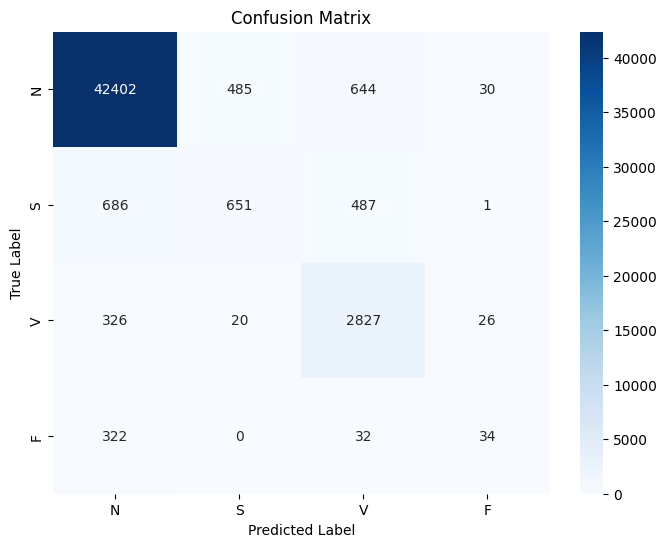

📋 Classification Report:
              precision    recall  f1-score   support

           N       0.97      0.97      0.97     43561
           S       0.56      0.36      0.44      1825
           V       0.71      0.88      0.79      3199
           F       0.37      0.09      0.14       388

    accuracy                           0.94     48973
   macro avg       0.65      0.58      0.58     48973
weighted avg       0.93      0.94      0.93     48973



NameError: name 'training_losses' is not defined

<Figure size 1000x500 with 0 Axes>

In [10]:
## -- NORMAL EVAL --- 
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score


# Structure: { predicted_label (str): { true_label (str): [window_id, window_id, ...] } }

model.eval()  # Set model to evaluation mode

all_preds = []
all_targets = []
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    # Here, we assume test_dataloader returns (inputs, targets, window_ids)
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)

        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())


test_loss /= len(test_dataloader)
test_accuracy = correct / total

macro_f1 = f1_score(all_targets, all_preds, average="macro")
weighted_f1 = f1_score(all_targets, all_preds, average="weighted")

print(f"📊 Macro F1-Score: {macro_f1:.4f}")
print(f"📊 Weighted F1-Score: {weighted_f1:.4f}")

print(f"\n📈 Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# Plotting Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=AAMI_CLASS_NAMES,
            yticklabels=AAMI_CLASS_NAMES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("./results/cm_inter_5_pulse.pdf", format='pdf', bbox_inches='tight') 
plt.show()

print("📋 Classification Report:")
print(classification_report(all_targets, all_preds, target_names=AAMI_CLASS_NAMES, zero_division=0))


# Plotting Training and Validation Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(len(training_losses)), training_losses, label='Training Loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("--- Parameters ---")
total_params_elements = 0
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}, numel: {param.numel()}, dtype: {param.dtype}")
    total_params_elements += param.numel()
print(f"Total elements in parameters: {total_params_elements}")

print("\n--- Buffers ---")
total_buffer_elements = 0
for name, buffer_val in model.named_buffers():
    print(f"{name}: {buffer_val.shape}, numel: {buffer_val.numel()}, dtype: {buffer_val.dtype}")
    total_buffer_elements += buffer_val.numel()
print(f"Total elements in buffers: {total_buffer_elements}")

--- Parameters ---
temporal_blocks.0.conv1.weight: torch.Size([4, 1, 9, 1]), numel: 36, dtype: torch.float32
temporal_blocks.0.conv1.input_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value: torch.Size([]), numel: 1, dtype: torch.float32
temporal_blocks.0.bn1.weight: torch.Size([4]), numel: 4, dtype: torch.float32
temporal_blocks.0.bn1.bias: torch.Size([4]), numel: 4, dtype: torch.float32
temporal_blocks.0.conv2.weight: torch.Size([4, 4, 9, 1]), numel: 144, dtype: torch.float32
temporal_blocks.0.conv2.input_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value: torch.Size([]), numel: 1, dtype: torch.float32
temporal_blocks.0.bn2.weight: torch.Size([4]), numel: 4, dtype: torch.float32
temporal_blocks.0.bn2.bias: torch.Size([4]), numel: 4, dtype: torch.float32
temporal_blocks.0.relu.act_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value: torch.Size([]), numel: 1, dtype: torch.float32
temporal_blocks.1.conv1.weight: torch.Size([8, 4, 9, 1]), nu

## **SAVE WEIGHTS**

In [ ]:
# --- Save model ---

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # If you want to save optimizer state
}, './tcn_model_final_7puls_40ep_inter_normal_normalziation_no_filter.pth')

print("Training Done, model weights are saved")


Training Done, model weights are saved


In [ ]:
# --- Inspect Weights --- 

print("\n🔍 Weight stats for all layers:")
for name, param in model.named_parameters():
    if "weight" in name:
        print(f"Layer {name} weight stats:")
        print(f"  min: {param.data.min().item()}")
        print(f"  max: {param.data.max().item()}")
        print(f"  std: {param.data.std().item()}")



## **Export onnx** 

In [21]:
# --- Export Model ---
from brevitas.export import export_qonnx
model.eval()
model = model.to(device)
dummy_input = torch.randn(1, 1, 1000, 1).to(device)
export_qonnx(
    model,
    dummy_input,
    export_path="/home/eveneiha/finn/workspace/finn/onnx/tcn_v41_test.onnx",
    input_names=["global_in"],
    output_names=["global_out"],
    opset_version=11
)

ir_version: 6
producer_name: "pytorch"
producer_version: "2.4.1"
graph {
  node {
    input: "global_in"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_1_output_0"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_2_output_0"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_output_0"
    output: "/temporal_blocks.0/conv1/input_quant/export_handler/Quant_output_0"
    name: "/temporal_blocks.0/conv1/input_quant/export_handler/Quant"
    op_type: "Quant"
    attribute {
      name: "narrow"
      i: 0
      type: INT
    }
    attribute {
      name: "rounding_mode"
      s: "ROUND"
      type: STRING
    }
    attribute {
      name: "signed"
      i: 1
      type: INT
    }
    domain: "onnx.brevitas"
  }
  node {
    input: "/temporal_blocks.0/conv1/weight_quant/export_handler/Constant_output_0"
    input: "/temporal_blocks.0/conv1/weight_quant/export_handler/Constant_1_output_0"
    input: "/temporal_blocks.0/co

# **TCN_INFERENCE MODULE**

In [9]:

# --- Redefinition of TCN to CNN for inference ---   
    
class SliceSelectorStep(nn.Module):
    def __init__(self, step = 1):
        super().__init__()
        self.step = step
               
    def forward(self, x):
        #print(f"Step size: {self.step}")
        return x[:, :, :65:self.step, :]  

class TemporalBlock2d_inf(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dropout=0.2, use_stride = False, last_block = False):
        super(TemporalBlock2d_inf, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.last_block = last_block
        
        if last_block:
            self.slice_selector_step = SliceSelectorStep(4)
            
        else: 
            self.slice_selector_step = None
        
        
        self.conv1 = qnn.QuantConv2d(
            n_inputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(stride, 1),
            padding=(0, 0),  # no padding – only compute valid outputs
            weight_quant=Int8WeightPerChannelFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(n_outputs)
        self.dropout1 = nn.Dropout(dropout)
         
        if use_stride: 
            stride = 4
        else:
            stride = 1
               
        self.conv2 = qnn.QuantConv2d(
            n_outputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(stride, 1),
            padding=(0, 0),
            weight_quant=Int8WeightPerChannelFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
        
        self.bn2 = nn.BatchNorm2d(n_outputs)
        self.dropout2 = nn.Dropout(dropout)

        self.relu = qnn.QuantReLU(return_quant_tensor=False, act_quant=Uint8ActPerTensorFloat, output_quant=Int8ActPerTensorFloat)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.slice_selector_step(x) if self.slice_selector_step is not None else x
        x = self.bn2(x) 
        x = self.relu(x)
        x = self.dropout2(x)
        return x


class TCN2d_inf(nn.Module):
    def __init__(self, custom_blocks: list, num_outputs: int):
        super(TCN2d_inf, self).__init__()
        self.temporal_blocks = nn.ModuleList(custom_blocks)
        last_out_channels = custom_blocks[-1].conv2.out_channels
                 
        self.fc = qnn.QuantConv2d(
            in_channels=last_out_channels,
            out_channels=num_outputs,
            kernel_size=(1, 1),
            weight_quant=Int8WeightPerChannelFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
                


    def forward(self, x):
        for block in self.temporal_blocks:
            x = block(x)
            
        x = self.fc(x)
        #x = self.out_quant(x)
        x = x.value if hasattr(x, 'value') else x
        x = x.reshape(x.size(0), -1)
        return x
    
    

block1 = TemporalBlock2d_inf(1, 4,  kernel_size=9,    stride=2,  dropout=0.05, use_stride = True) 
block2 = TemporalBlock2d_inf(4, 8,  kernel_size=9,    stride=1,  dropout=0.05,  last_block=True) # if this is true then next dilation must be D3= D3_old/D2
block3 = TemporalBlock2d_inf(8, 16, kernel_size=9,    stride=1,  dropout=0.05) # if this is true then next dilation must be D3= D3_old/D2

# print(pruning_map["block3_conv2"])
# print(pruning_map["block2_conv2"])

custom_blocks_inf = [block1, block2, block3]




In [10]:

# Instantiate model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print([type(block) for block in custom_blocks_inf])
model_inf = TCN2d_inf(custom_blocks=custom_blocks_inf, num_outputs=4).to(device)


# --- Load Trained Model Weights ---
# CPU:
checkpoint = torch.load('./tcn_model_final_7puls_40ep_inter_normal_normalziation.pth', map_location=torch.device('cpu'))
model_inf.load_state_dict(checkpoint['model_state_dict'], strict=False)


model_inf.eval()



tcn = TCN2d_inf(custom_blocks_inf, num_outputs=4)  # or whatever class count
# print(sum(p.numel() for p in tcn.parameters()))

n_param = sum(p.numel() for p in tcn.parameters())
n_buffer = sum(b.numel() for b in tcn.buffers())
print(f'Parameters: {n_param:,}\nBuffers   : {n_buffer:,}\nTotal     : {n_param + n_buffer:,}')

info = summary(tcn,
               input_size=(1, 1, 665, 1),
               verbose=0,            # suppress the table
               col_names=())         # we only want the object

total_params = sum(p.numel() for p in tcn.parameters())
total_buffers = sum(b.numel() for b in tcn.buffers())

size_bytes = (total_params + total_buffers) * 1        # training: float32
size_kb    = size_bytes / 1024
size_mb    = size_kb / 1024

print(f'Parameters   : {total_params:,}')
print(f'Buffers      : {total_buffers:,}')
print(f'Total tensors: {total_params + total_buffers:,}')
print(f'Size  (bytes): {size_bytes}')
print(f'Size    (kB): {size_kb:.3f}')
print(f'Size    (MB): {size_mb:.6f}')



summary(model_inf, input_size=(1, 1, 665, 1))#833  # (batch_size, channels, sequence_length)





[<class '__main__.TemporalBlock2d_inf'>, <class '__main__.TemporalBlock2d_inf'>, <class '__main__.TemporalBlock2d_inf'>]
Parameters: 4,686
Buffers   : 196
Total     : 4,882


/tmp/ipykernel_2524317/2854365586.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./tcn_model_final_7puls_40ep_inter_normal_normalziation.pth', 

Parameters   : 4,686
Buffers      : 196
Total tensors: 4,882
Size  (bytes): 4882
Size    (kB): 4.768
Size    (MB): 0.004656


Layer (type:depth-idx)                                                      Output Shape              Param #
TCN2d_inf                                                                   [1, 4]                    --
├─ModuleList: 1-19                                                          --                        (recursive)
│    └─TemporalBlock2d_inf: 2-1                                             [1, 4, 81, 1]             162
│    │    └─QuantConv2d: 3-1                                                [1, 4, 329, 1]            37
├─QuantConv2d: 1-18                                                         --                        (recursive)
│    └─ActQuantProxyFromInjector: 2-20                                      --                        (recursive)
│    │    └─FusedActivationQuantProxy: 3-38                                 --                        (recursive)
├─ModuleList: 1-19                                                          --                        (recursive)
│   

## **Train sliced model**


In [ ]:
# --- Training ---
num_epochs = 5
training_losses = []
validation_losses = []

model_inf.train()  # Set model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    batch_count = 0

    # Training loop over batches
    for inputs, targets, _ in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model_inf(inputs)  # Forward pass
        loss = criterion(outputs, targets)
        loss.backward()         # Backpropagation
        optimizer.step()        # Update weights

        running_loss += loss.item()
        batch_count += 1

    train_loss = running_loss / batch_count
    training_losses.append(train_loss)

    # --- Validation ---
    model_inf.eval()  # Switch to evaluation mode
    val_running_loss = 0.0
    val_batch_count = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs_val, targets_val, _ in val_dataloader:
            inputs_val = inputs_val.to(device)
            targets_val = targets_val.to(device)
            outputs_val = model_inf(inputs_val)
            loss_val = criterion(outputs_val, targets_val)

            val_running_loss += loss_val.item()
            val_batch_count += 1

            # Compute accuracy for the batch
            _, predicted = torch.max(outputs_val, 1)
            correct += (predicted == targets_val).sum().item()
            total += targets_val.size(0)

    val_loss = val_running_loss / val_batch_count
    validation_losses.append(val_loss)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    model_inf.train() 

## **EVAL**

✅ Test Accuracy: 0.9428
📊 Macro F1-Score: 0.6072
📊 Weighted F1-Score: 0.9389


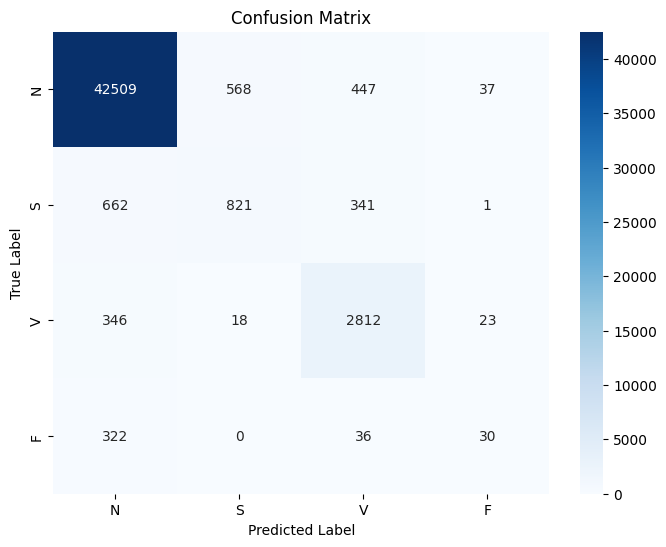

📋 Classification Report:
              precision    recall  f1-score   support

           N       0.97      0.98      0.97     43561
           S       0.58      0.45      0.51      1825
           V       0.77      0.88      0.82      3199
           F       0.33      0.08      0.13       388

    accuracy                           0.94     48973
   macro avg       0.66      0.60      0.61     48973
weighted avg       0.94      0.94      0.94     48973



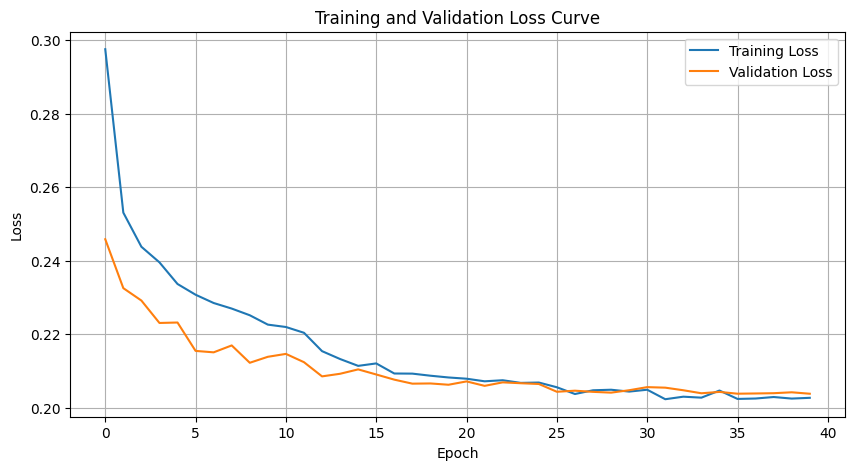

In [21]:
# eval
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score


# Initialize the nested mapping:
# Structure: { predicted_label (str): { true_label (str): [window_id, window_id, ...] } }

model_inf.eval()  # Set model to evaluation mode

all_preds = []
all_targets = []
correct = 0
total = 0

# If needed for other purposes, you can keep lists of misclassified tensors.
misclassified_inputs = []
misclassified_preds = []
misclassified_targets = []

with torch.no_grad():
    # Here, we assume test_dataloader returns (inputs, targets, window_ids)
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)
        inputs = inputs[:, :,167:832, :]

        targets = targets.to(device)
        outputs = model_inf(inputs)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())


test_accuracy = correct / total

print(f"✅ Test Accuracy: {test_accuracy:.4f}")

macro_f1 = f1_score(all_targets, all_preds, average="macro")
weighted_f1 = f1_score(all_targets, all_preds, average="weighted")

print(f"📊 Macro F1-Score: {macro_f1:.4f}")
print(f"📊 Weighted F1-Score: {weighted_f1:.4f}")
# Plotting Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=AAMI_CLASS_NAMES,
            yticklabels=AAMI_CLASS_NAMES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("./results/cm_inter_5_pulse_inf.pdf", format='pdf', bbox_inches='tight') 

plt.show()

print("📋 Classification Report:")
print(classification_report(all_targets, all_preds, target_names=AAMI_CLASS_NAMES, zero_division=0))


# Plotting Training and Validation Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(len(training_losses)), training_losses, label='Training Loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
from brevitas.export import export_qonnx
from onnx import shape_inference


model_inf.eval()
model_inf = model_inf.to(device)
dummy_input = torch.randn(1, 1, 665, 1).to(device)
export_qonnx(
    model_inf,
    dummy_input,
    export_path="/home/eveneiha/finn/workspace/finn/onnx/tcn_v41_inf.onnx",
    input_names=["global_in"],
    output_names=["global_out"],
    opset_version=11
)

ir_version: 6
producer_name: "pytorch"
producer_version: "2.4.1"
graph {
  node {
    input: "global_in"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_1_output_0"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_2_output_0"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_output_0"
    output: "/temporal_blocks.0/conv1/input_quant/export_handler/Quant_output_0"
    name: "/temporal_blocks.0/conv1/input_quant/export_handler/Quant"
    op_type: "Quant"
    attribute {
      name: "narrow"
      i: 0
      type: INT
    }
    attribute {
      name: "rounding_mode"
      s: "ROUND"
      type: STRING
    }
    attribute {
      name: "signed"
      i: 1
      type: INT
    }
    domain: "onnx.brevitas"
  }
  node {
    input: "/temporal_blocks.0/conv1/weight_quant/export_handler/Constant_output_0"
    input: "/temporal_blocks.0/conv1/weight_quant/export_handler/Constant_1_output_0"
    input: "/temporal_blocks.0/co

## **ONNXRUNTIME INFERENCE**

In [ ]:
# Export


import torch
import torch.nn as nn
import brevitas.nn as qnn
import json
import onnx

# --- Paste your model definition code here ---
# (Includes potentially simplified UnsignedQuantIdentity, SliceSelector, etc.)
# ... (rest of your model definition, instantiation, weight loading) ...

# --- Set model to evaluation mode ---
model_inf.eval()
print("Model set to evaluation mode.")

# --- Prepare Dummy Input ---
# ... (your dummy input definition) ...
print(f"Using dummy input shape: {dummy_input.shape}")

# --- Define ONNX export parameters ---
onnx_file_path = "tcn_quantized_model_torch_export.onnx" # New name maybe
input_names = ["input"]
output_names = ["output"]
opset_version = 11 # Keep opset 13

# --- Export the model using torch.onnx.export ---
try:
    print(f"Exporting model using torch.onnx.export to: {onnx_file_path}")
    torch.onnx.export(model_inf,
                      dummy_input,
                      onnx_file_path,
                      export_params=True,
                      opset_version=opset_version,
                      do_constant_folding=True, # Keep True
                      input_names=input_names,
                      output_names=output_names,
                      dynamic_axes={'input': {0: 'batch_size', 2: 'time'},
                                    'output': {0: 'batch_size'}}
                     )
    print("ONNX export completed successfully.")

    # Optional: Verify the exported model using ONNX
    onnx_model = onnx.load(onnx_file_path)
    onnx.checker.check_model(onnx_model)
    print("ONNX model check passed.")

except Exception as e:
    print(f"ONNX export failed: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
import os # Import the os module first

# --- Configure PYTHONPATH for Jupyter ---
# This sets the environment variable for the *current* Python process (the Jupyter kernel)
# Replace "/home/eveneiha/finn" with the actual path to the root of your FINN repository.
# This path should contain the 'finn' directory.
finn_root_path = "/home/eveneiha/finn"
if finn_root_path not in os.environ.get('PYTHONPATH', '').split(os.pathsep):
    os.environ['PYTHONPATH'] = finn_root_path + os.pathsep + os.environ.get('PYTHONPATH', '')
    print(f"Added {finn_root_path} to PYTHONPATH")
else:
    print(f"{finn_root_path} already in PYTHONPATH")

import torch
import torch.nn as nn
import numpy as np
# from finn.custom_op.fpgadataflow import * 
# import onnxruntime as ort # No longer needed for execution here
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.datatype import DataType
from qonnx.core.onnx_exec import execute_onnx # Use QONNX execution

# --- Assumed: PyTorch Model Definitions are available ---
# from your_pytorch_model_definition_file import TCN2d_inf, ...

import logging 

logging.getLogger("qonnx.core.datatype").setLevel(logging.WARNING)

# --- Configuration ---
pytorch_model_weights_path = "/home/eveneiha/finn/workspace/ml/model/tcn_model_v41_avg_pool.pth"
final_onnx_model_path = "/home/eveneiha/finn/workspace/finn/onnx/05tcn_befor_hw.onnx"
num_samples_to_test = 20
input_data_path = "/home/eveneiha/finn/workspace/ml/data/preprocessed/test.pt"
input_slice_start = 168
input_slice_end = 833

# --- Load Data (Corrected Key) ---
print("Loading data from .pt file...")
inputs = None # Initialize to prevent NameError later
try:
    data_dict = torch.load(input_data_path, map_location=torch.device('cpu'))
    if isinstance(data_dict, dict):
        input_key = 'inputs' # Corrected key
        if input_key not in data_dict:
             possible_keys = [k for k, v in data_dict.items() if isinstance(v, (torch.Tensor, np.ndarray))]
             raise KeyError(f"Input key '{input_key}' not found. Possible keys: {possible_keys}")
        inputs_tensor = data_dict[input_key]
        if isinstance(inputs_tensor, torch.Tensor):
            inputs = inputs_tensor.detach().numpy().astype(np.float32)
        elif isinstance(inputs_tensor, np.ndarray):
            inputs = inputs_tensor.astype(np.float32)
        else:
            raise TypeError(f"Loaded input data is not Tensor/ndarray: {type(inputs_tensor)}")
        print(f"Loaded input data shape: {inputs.shape}")
    # Add elif for direct tensor or list/tuple if needed
    else:
         raise TypeError(f"Unexpected data type loaded: {type(data_dict)}")
except FileNotFoundError:
    print(f"ERROR: Input data file not found at {input_data_path}")
except KeyError as e:
    print(f"ERROR: Could not find expected key in the loaded .pt file: {e}")
except Exception as e:
    print(f"ERROR loading or processing input data: {e}")

# # --- Load PyTorch Model ---
# print("Loading PyTorch model...")
# model_inf = None # Initialize
# try:
#     NUM_OUTPUTS = 5
#     # Instantiate the architecture (replace placeholders with actual imports)
#     block1_pt=TemporalBlock2d_inf(1,4,kernel_size=9,stride=2,dropout=0.05,use_stride=True); block2_pt=TemporalBlock2d_inf(4,8,kernel_size=9,stride=1,dropout=0.05,last_block=True); block3_pt=TemporalBlock2d_inf(8,16,kernel_size=9,stride=1,dropout=0.05); custom_blocks_inf_pt=[block1_pt,block2_pt,block3_pt]
#     model_inf = TCN2d_inf(custom_blocks=custom_blocks_inf_pt, num_outputs=NUM_OUTPUTS)

#     checkpoint = torch.load(pytorch_model_weights_path, map_location=torch.device('cpu'))
#     state_dict = checkpoint.get('model_state_dict', checkpoint)
#     model_inf.load_state_dict(state_dict)
#     model_inf.eval()
#     print("PyTorch model loaded.")
# except FileNotFoundError:
#     print(f"ERROR: PyTorch weights file not found: {pytorch_model_weights_path}")
# except Exception as e:
#     print(f"ERROR loading PyTorch model or weights: {e}")

# --- Load ONNX Model ---
print(f"Loading ONNX model: {final_onnx_model_path}...")
model_for_sim = None
input_name_onnx = None
output_name_onnx = None
try:
    if not os.path.exists(final_onnx_model_path):
         raise FileNotFoundError(f"ONNX model file not found at {final_onnx_model_path}")
    model_for_sim = ModelWrapper(final_onnx_model_path)
    # Optional: Clean up initializers from inputs if needed (run only once on the file)
    # model_for_sim = model_for_sim.transform(RemoveStaticGraphInputs())
    # model_for_sim.save(final_onnx_model_path) # Overwrite with cleaned version
    input_name_onnx = model_for_sim.graph.input[0].name
    output_name_onnx = model_for_sim.graph.output[0].name
    print(f"ONNX Input Name: {input_name_onnx}")
    print(f"ONNX Output Name: {output_name_onnx}")
    print("ONNX model loaded.")
except FileNotFoundError as e:
     print(f"ERROR: {e}")
except Exception as e:
    print(f"ERROR loading ONNX model: {e}")


# --- Comparison Loop ---
print("\n--- Starting Comparison ---")
max_abs_diff = 0.0
max_rel_diff = 0.0
mismatched_samples = 0
samples_compared = 0
# Check if everything loaded correctly before starting
can_compare = model_inf is not None and inputs is not None and model_for_sim is not None

if can_compare:
    num_to_run = min(num_samples_to_test, inputs.shape[0])
    if num_to_run == 0:
        print("ERROR: No input samples found to run comparison.")
    else:
        for i in range(num_to_run):
            print(f"\n--- Sample {i} ---")
            samples_compared += 1 # Increment here, even if error occurs below

            # 1. Prepare Input for PyTorch
            try:
                # Adjust reshape as needed for your data and model
                pytorch_input_np = inputs[i].reshape(1, 1, 1000, 1)
                pytorch_input_tensor = torch.from_numpy(pytorch_input_np).float()
                # print(f"PyTorch Input Shape: {pytorch_input_tensor.shape}")
            except Exception as e:
                print(f"ERROR preparing PyTorch input: {e}")
                continue

            # 2. Run PyTorch Inference
            try:
                with torch.no_grad():
                    pytorch_output_tensor = model_inf(pytorch_input_tensor)
                pytorch_output_np = pytorch_output_tensor.detach().numpy()
                # print(f"PyTorch Output Shape: {pytorch_output_np.shape}")
            except Exception as e:
                print(f"ERROR running PyTorch inference: {e}")
                continue

            # 3. Prepare Input for ONNX Simulation
            try:
                onnx_input_sliced_nchw = pytorch_input_np[:, :, input_slice_start:input_slice_end, :]
                # print(f"ONNX Simulation Input Shape (Sliced NCHW): {onnx_input_sliced_nchw.shape}")
                # execute_onnx usually prefers float input matching original model input type
                onnx_input_dict = {input_name_onnx: onnx_input_sliced_nchw.astype(np.float32)}
            except Exception as e:
                print(f"ERROR preparing ONNX input: {e}")
                continue

            # 4. Run ONNX Inference (using execute_onnx)
            try:
                onnx_output_dict = execute_onnx(model_for_sim, onnx_input_dict, return_full_exec_context=False)
                onnx_output_np = onnx_output_dict[output_name_onnx]
                # print(f"ONNX Sim Output Shape: {onnx_output_np.shape}")
            except Exception as e:
                print(f"ERROR running ONNX simulation (execute_onnx): {e}")
                continue

            # 5. Compare Outputs
            if pytorch_output_np.shape != onnx_output_np.shape:
                print(f"ERROR: Shape mismatch! PyTorch={pytorch_output_np.shape}, ONNX={onnx_output_np.shape}")
                mismatched_samples += 1
                continue

            try:
                onnx_output_float = onnx_output_np.astype(np.float32)
                pytorch_output_float = pytorch_output_np.astype(np.float32)
                atol = 1e-5
                rtol = 1e-4

                if not np.allclose(pytorch_output_float, onnx_output_float, rtol=rtol, atol=atol):
                    print(f"WARNING: Numerical mismatch detected for sample {i}!")
                    mismatched_samples += 1
                    abs_diff = np.abs(pytorch_output_float - onnx_output_float)
                    rel_diff = abs_diff / (np.maximum(np.abs(pytorch_output_float), np.abs(onnx_output_float)) + 1e-9)
                    current_max_abs = abs_diff.max()
                    current_max_rel = rel_diff.max()
                    print(f"   Max Absolute Difference: {current_max_abs}")
                    print(f"   Max Relative Difference: {current_max_rel}")
                    max_abs_diff = max(max_abs_diff, current_max_abs)
                    max_rel_diff = max(max_rel_diff, current_max_rel)
                # else: # Optionally print match confirmation
                #    print("   Outputs match numerically (within tolerance).")
            except Exception as e:
                print(f"ERROR during comparison for sample {i}: {e}")
                mismatched_samples += 1

# --- Final Summary ---
print("\n--- Comparison Summary ---")
if not can_compare:
     print("ERROR: Cannot perform comparison due to missing model(s) or ONNX session/file.")
elif samples_compared == 0:
     print("ERROR: No samples were successfully processed for comparison.")
elif mismatched_samples == 0:
    print(f"✅ All {samples_compared} tested samples match between PyTorch and ONNX simulation (within tolerance).")
else:
    print(f"❌ Mismatches found in {mismatched_samples}/{samples_compared} samples!")
    print(f"   Overall Max Absolute Difference Found: {max_abs_diff:.6f}")
    print(f"   Overall Max Relative Difference Found: {max_rel_diff:.6f}")
print("--------------------------")

## **QUANTIZED INFERENCE MODULE RUNTIME**

In [ ]:
# ==============================================================
#                    IMPORTS
# ==============================================================
import os
import time
from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm  # For progress bar

import onnxruntime as ort

# --- Metrics & Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# ==============================================================
#                    CONFIGURATION
# ==============================================================

# --- Paths ---
# Directory where preprocessed .pt files are stored
save_dir = '/home/eveneiha/finn/workspace/ml/data/preprocessed'
# Path to your exported & quantized ONNX model
onnx_model_path = "/home/eveneiha/finn/workspace/finn/output_dir/tcn_POSTSYNTH.onnx"

# --- DataLoader Settings ---
# !! CRITICAL for memory issues: Start with a VERY SMALL batch size !!
# Try 4, 8, or 16. Increase only if it works without crashing.
batch_size = 4
# Setting num_workers=0 can sometimes help with debugging memory issues
num_workers = 0

# --- Evaluation Settings ---
# Define your AAMI class names (Make sure this matches your training order)
#AAMI_CLASS_NAMES = ['N', 'S', 'V', 'F', 'Q'] # Example - Replace/Confirm

# --- Debugging Settings ---
# Set to a positive integer (e.g., 50) to only process that many batches for testing
# Set to None or 0 to process the entire dataset
MAX_BATCHES_TO_PROCESS = None

# ==============================================================
#          HELPER FUNCTION: ONNX Type to NumPy Dtype
# ==============================================================
def get_numpy_dtype(onnx_type_str):
    """Maps ONNX tensor type strings to NumPy dtypes."""
    type_map = {
        'tensor(float)': np.float32,
        'tensor(double)': np.float64,
        'tensor(int8)': np.int8,
        'tensor(uint8)': np.uint8,
        'tensor(int16)': np.int16,
        'tensor(uint16)': np.uint16,
        'tensor(int32)': np.int32,
        'tensor(uint32)': np.uint32,
        'tensor(int64)': np.int64,
        'tensor(uint64)': np.uint64,
        'tensor(bool)': np.bool_,
        'tensor(float16)': np.float16, # Common alternative name
        'tensor(bfloat16)': np.float16 # Requires appropriate numpy/torch version
    }
    dtype = type_map.get(onnx_type_str)
    if dtype is None:
         # Fallback for slightly different naming conventions if needed
         if 'float16' in onnx_type_str: dtype = np.float16
         elif 'float' in onnx_type_str: dtype = np.float32 # Default float
         # Add more fallbacks if necessary based on error messages
         else:
            raise ValueError(f"Unsupported or unrecognized ONNX type string: {onnx_type_str}")
    return dtype

# ==============================================================
#                    DATA LOADING & PREPARATION
# ==============================================================

# --- Define Dataset Class ---
class PreprocessedECGDataset(Dataset):
    def __init__(self, inputs, labels, win_ids):
        if not (inputs.size(0) == labels.size(0) == len(win_ids)):
             raise ValueError(f"Mismatch in dataset sizes! Inputs: {inputs.size(0)}, Labels: {labels.size(0)}, WinIDs: {len(win_ids)}")
        self.inputs = inputs
        self.labels = labels
        # Ensure win_ids is a list or compatible sequence for indexing
        self.win_ids = list(win_ids) if not isinstance(win_ids, list) else win_ids

    def __len__(self):
        return self.inputs.size(0) # Use tensor size for length

    def __getitem__(self, idx):
        # Return items directly by index
        return self.inputs[idx], self.labels[idx], self.win_ids[idx]

# --- Load Data and Create DataLoaders ---
test_dataloader = None
test_dataset_size = 0
try:
    print(f"Loading test data from: {os.path.join(save_dir, 'test.pt')}")
    if not os.path.exists(os.path.join(save_dir, "test.pt")):
        raise FileNotFoundError(f"Required data file not found: {os.path.join(save_dir, 'test.pt')}")

    test_data = torch.load(os.path.join(save_dir, "test.pt"))
    test_inputs = test_data["inputs"]
    test_labels = test_data["labels"]
    test_ids = test_data["window_ids"]
    print("Test data loaded successfully.")

    print("Creating test dataset...")
    test_dataset = PreprocessedECGDataset(test_inputs, test_labels, test_ids)
    test_dataset_size = len(test_dataset)
    print(f"DEBUG: Total number of samples in test_dataset: {test_dataset_size}")

    if test_dataset_size == 0:
        print("Warning: Test dataset is empty.")

    print(f"Creating test dataloader with batch_size = {batch_size}, num_workers = {num_workers}...")
    test_dataloader = DataLoader(test_dataset,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers)
    print("Test dataloader created.")

except FileNotFoundError as e:
    print(f"FATAL ERROR: {e}")
    exit()
except ValueError as e:
    print(f"FATAL ERROR during dataset creation: {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    import traceback
    traceback.print_exc()
    exit()

if test_dataloader is None or test_dataset_size == 0:
     print("FATAL ERROR: Test dataloader could not be created or dataset is empty. Exiting.")
     exit()

# ==============================================================
#                ONNX RUNTIME SESSION SETUP
# ==============================================================
session = None
input_name = None
output_names = None
input_type_np = None

print(f"\nLoading ONNX model from: {onnx_model_path}")
if not os.path.exists(onnx_model_path):
    print(f"FATAL ERROR: ONNX model file not found at {onnx_model_path}")
    exit()

try:
    sess_options = ort.SessionOptions()
    # Optional: Fine-tune session options if needed
    # sess_options.intra_op_num_threads = 1 # Example: Limit threads

    print("Creating ONNX Runtime session...")
    session = ort.InferenceSession(onnx_model_path, sess_options, providers=['CPUExecutionProvider'])
    print("ONNX Runtime session created successfully.")
    print(f"Using Execution Provider(s): {session.get_providers()}")

    # --- Get Input/Output Details ---
    input_desc = session.get_inputs()[0]
    output_descs = session.get_outputs() # Get all outputs

    input_name = input_desc.name
    input_shape_model = input_desc.shape
    input_type_model_ort = input_desc.type # String like 'tensor(float)'

    output_names = [o.name for o in output_descs]
    # Assuming the primary output is the first one for classification
    output_name = output_descs[0].name
    output_shape_model = output_descs[0].shape
    output_type_model_ort = output_descs[0].type

    print(f"Model Input : Name='{input_name}', Shape={input_shape_model}, Type={input_type_model_ort}")
    print(f"Model Output(s): Names={output_names}") # Show all output names
    print(f"  - Primary Output for ArgMax: Name='{output_name}', Shape={output_shape_model}, Type={output_type_model_ort}")

    # --- Determine Expected NumPy Input Type ---
    input_type_np = get_numpy_dtype(input_type_model_ort)
    print(f"Expecting NumPy input type for ONNX Runtime: {input_type_np}")

except Exception as e:
    print(f"\nFATAL ERROR: Failed to load ONNX model or create session: {e}")
    import traceback
    traceback.print_exc()
    exit() # Stop if model loading fails









# ==============================================================
#                    EVALUATION
# ==============================================================

# --- Initialization ---
all_preds_np = []
all_targets_np = []
misclassified_map = defaultdict(lambda: defaultdict(list))
correct = 0
total = 0
inference_times = []
processed_batches = 0

print(f"\nStarting evaluation on the test set using ONNX Runtime...")
print(f"Target Class Names: {AAMI_CLASS_NAMES}")
if MAX_BATCHES_TO_PROCESS:
    print(f"DEBUG: Will process a maximum of {MAX_BATCHES_TO_PROCESS} batches.")

# --- Evaluation Loop ---
try:
    # Ensure session is valid
    if session is None:
        raise RuntimeError("ONNX Runtime session is not initialized.")

    # Use torch.no_grad() if any torch operations remain inside loop, otherwise optional
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(tqdm(test_dataloader, desc="Evaluating")):

            # --- Subset Processing Check ---
            if MAX_BATCHES_TO_PROCESS and batch_idx >= MAX_BATCHES_TO_PROCESS:
                print(f"\nDEBUG: Stopping loop early after reaching {MAX_BATCHES_TO_PROCESS} batches.")
                break

            # --- Data Unpacking and Validation ---
            if len(batch_data) != 3:
                 print(f"\nWarning: Dataloader expected to yield 3 items (inputs, targets, win_ids), but got {len(batch_data)} at batch {batch_idx}. Skipping batch.")
                 continue
            inputs_torch, targets_torch, win_ids = batch_data

            # Add input shape debug print for the first batch
            if batch_idx == 0:
                print(f"\nDEBUG: Shape of first input batch tensor: {inputs_torch.shape}")
                print(f"DEBUG: Dtype of first input batch tensor: {inputs_torch.dtype}")
                # Check if batch size matches dataloader setting
                if inputs_torch.shape[0] != batch_size and len(test_dataloader) > 1:
                     print(f"Warning: Input batch size {inputs_torch.shape[0]} doesn't match DataLoader batch_size {batch_size}. This might happen on the last batch.")


            # --- 1. Prepare Inputs for ONNX Runtime ---
            # Convert to NumPy array with the correct dtype expected by the model input
            try:
                 inputs_np = inputs_torch.cpu().numpy().astype(input_type_np)
            except Exception as e:
                 print(f"\nError converting input batch {batch_idx} to NumPy with dtype {input_type_np}: {e}")
                 print(f"Input tensor dtype was: {inputs_torch.dtype}")
                 continue # Skip this batch

            # --- 2. Prepare Targets (keep as NumPy on CPU) ---
            targets_np = targets_torch.cpu().numpy()

            # --- 3. Run ONNX Inference ---
            try:
                start_time = time.perf_counter()
                # Provide input as a dictionary {input_name: input_data}
                outputs_list = session.run(output_names, {input_name: inputs_np})
                end_time = time.perf_counter()
                inference_times.append(end_time - start_time)

                # outputs_list contains results for all model outputs in order of output_names
                # Get the primary output for classification (assuming it's the first one)
                output_np = outputs_list[0]

            except Exception as e:
                print(f"\nError during ONNX Runtime inference at batch {batch_idx}: {e}")
                print(f"Input shape provided: {inputs_np.shape}, dtype: {inputs_np.dtype}")
                # Depending on severity, you might want to 'continue' or 'break' or 'exit()'
                break # Stop evaluation if inference fails

            # --- 4. Process Output to get Predictions ---
            try:
                # Argmax assumes the class dimension is axis 1 (shape: batch, num_classes)
                # Verify this assumption based on printed model output shape
                if len(output_np.shape) < 2 or output_np.shape[1] != len(AAMI_CLASS_NAMES):
                     print(f"\nWarning: Unexpected output shape {output_np.shape} at batch {batch_idx}. Cannot reliably perform argmax for {len(AAMI_CLASS_NAMES)} classes along axis 1. Skipping batch.")
                     continue

                predicted_np = np.argmax(output_np, axis=1)
            except Exception as e:
                 print(f"\nError processing model output (argmax) at batch {batch_idx}: {e}")
                 print(f"Output shape was: {output_np.shape}")
                 continue # Skip batch if output processing fails

            # --- 5. Update Metrics ---
            correct += np.sum(predicted_np == targets_np)
            total += targets_np.shape[0]

            all_preds_np.extend(predicted_np)
            all_targets_np.extend(targets_np)

            # --- 6. Track Misclassifications ---
            misclassified_mask = predicted_np != targets_np
            if np.any(misclassified_mask):
                # Iterate over the samples *in this batch* that were misclassified
                for i in np.where(misclassified_mask)[0]:
                    pred_label_idx = predicted_np[i]
                    true_label_idx = targets_np[i]

                    # Get window ID safely
                    win_id = win_ids[i] if i < len(win_ids) else "Unknown_WinID"

                    # Ensure indices are valid before accessing AAMI_CLASS_NAMES
                    if 0 <= pred_label_idx < len(AAMI_CLASS_NAMES) and 0 <= true_label_idx < len(AAMI_CLASS_NAMES):
                         pred_label = AAMI_CLASS_NAMES[pred_label_idx]
                         true_label = AAMI_CLASS_NAMES[true_label_idx]
                         misclassified_map[pred_label][true_label].append(win_id)
                    else:
                         print(f"Warning: Index out of bounds at batch {batch_idx}, index {i}. Pred: {pred_label_idx}, True: {true_label_idx}. WinID: {win_id}. Skipping misclassification log.")

            processed_batches += 1

except Exception as e:
    print(f"\nAn unexpected error occurred during the evaluation loop at batch index {batch_idx}: {e}")
    import traceback
    traceback.print_exc()
    # Optionally add exit() here if you want it to stop completely on any loop error






# ==============================================================
#                    RESULTS & REPORTING
# ==============================================================
print(f"\nEvaluation loop finished after processing {processed_batches} batches.")

if total > 0:
    test_accuracy = correct / total
    avg_inference_time_ms = (np.mean(inference_times) * 1000) if inference_times else 0
    print("\n--- Evaluation Summary ---")
    print(f"✅ Test Accuracy : {test_accuracy:.4f} ({correct}/{total})")
    print(f"⏱️ Avg Inference Time / Batch: {avg_inference_time_ms:.3f} ms")

    # --- Metrics Calculation (using sklearn) ---
    try:
        print("\nCalculating F1-Scores and Classification Report...")
        # Ensure arrays are not empty before calculating metrics
        if not all_targets_np or not all_preds_np:
             print("Cannot calculate metrics: Prediction or target lists are empty.")
        else:
            macro_f1 = f1_score(all_targets_np, all_preds_np, average="macro", zero_division=0)
            weighted_f1 = f1_score(all_targets_np, all_preds_np, average="weighted", zero_division=0)

            print(f"📊 Macro F1-Score : {macro_f1:.4f}")
            print(f"📊 Weighted F1-Score: {weighted_f1:.4f}")

            print("\n📋 Classification Report:")
            # Check if target names length matches unique labels found
            unique_labels = np.unique(np.concatenate((all_targets_np, all_preds_np)))
            target_names_to_use = AAMI_CLASS_NAMES
            if len(unique_labels) > len(AAMI_CLASS_NAMES) or max(unique_labels) >= len(AAMI_CLASS_NAMES):
                 print(f"Warning: Labels found ({unique_labels}) exceed defined AAMI_CLASS_NAMES length ({len(AAMI_CLASS_NAMES)}). Using numeric labels for report.")
                 target_names_to_use = [str(i) for i in range(max(unique_labels) + 1)]
            elif len(unique_labels) < len(AAMI_CLASS_NAMES):
                 print(f"Warning: Not all classes defined in AAMI_CLASS_NAMES were present in predictions/targets. Report may omit some classes.")
                 # Optionally filter target_names_to_use based on unique_labels present


            print(classification_report(all_targets_np, all_preds_np,
                                        target_names=target_names_to_use, zero_division=0))

    except Exception as e:
        print(f"\nError calculating sklearn metrics: {e}")

    # --- Plotting Confusion Matrix ---
    try:
        print("\nGenerating Confusion Matrix...")
        if not all_targets_np or not all_preds_np:
            print("Cannot generate confusion matrix: Prediction or target lists are empty.")
        else:
            cm = confusion_matrix(all_targets_np, all_preds_np)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=AAMI_CLASS_NAMES, # Use original names for labels if possible
                        yticklabels=AAMI_CLASS_NAMES)
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.title("Confusion Matrix (ONNX Runtime)")
            # Consider saving the plot instead of just showing, especially if running non-interactively
            # plt.savefig("confusion_matrix_onnx.png")
            plt.show() # Display the plot
    except Exception as e:
        print(f"\nError generating confusion matrix plot: {e}")


    # --- Print Misclassified Samples Summary ---
    print("\n🔍 Misclassified Window IDs Summary:")
    if not misclassified_map:
        print("  No misclassifications found.")
    else:
        count = 0
        MAX_MISCLASSIFIED_EXAMPLES_TO_PRINT = 5 # Limit printing per category
        for pred_label, true_labels_dict in sorted(misclassified_map.items()):
            for true_label, win_ids_list in sorted(true_labels_dict.items()):
                 example_ids = win_ids_list[:MAX_MISCLASSIFIED_EXAMPLES_TO_PRINT]
                 ellipsis = '...' if len(win_ids_list) > MAX_MISCLASSIFIED_EXAMPLES_TO_PRINT else ''
                 print(f"  - Predicted '{pred_label}', True '{true_label}': {len(win_ids_list):,} samples (e.g., {example_ids}{ellipsis})")
                 count += len(win_ids_list)
        print(f"  Total misclassified samples logged: {count:,}")


else:
    print("\nEvaluation could not be completed. No samples processed (total=0).")
    if not test_dataloader:
         print("Reason: Test dataloader was not created.")
    elif processed_batches == 0:
         print("Reason: The evaluation loop did not process any batches.")

print("\n--- Evaluation Script Finished ---")

# **MODEL TIME COMPARISON**

In [13]:

import torch
import time
from fvcore.nn import FlopCountAnalysis, parameter_count_table

def benchmark_model(model, input_tensor, name="Model", runs=100, warmup=10, verbose=True):
    model.eval()
    input_tensor = input_tensor.to(next(model.parameters()).device)

    # Warmup
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(input_tensor)

    # Measure inference time
    times = []
    with torch.no_grad():
        for _ in range(runs):
            start = time.time()
            _ = model(input_tensor)
            end = time.time()
            times.append(end - start)

    avg_time_ms = 1000 * sum(times) / len(times)
    std_time_ms = 1000 * (sum((t - sum(times)/len(times))**2 for t in times) / len(times))**0.5

    # FLOPs
    try:
        flops = FlopCountAnalysis(model, input_tensor)
        total_flops = flops.total()
        flops_breakdown = flops.by_module()
    except Exception as e:
        total_flops = None
        flops_breakdown = None
        if verbose:
            print(f"FLOP analysis failed for {name}: {e}")

    # Parameters
    param_table = parameter_count_table(model)

    if verbose:
        print(f"\n📊 Benchmark for {name}")
        print(f"  ⏱️ Avg Inference Time: {avg_time_ms:.2f} ms ± {std_time_ms:.2f} ms over {runs} runs")
        print(f"  🧮 Parameters:\n{param_table}")
        if total_flops is not None:
            print(f"  🔢 Total FLOPs: {total_flops:,}")
            print(f"  🔍 FLOPs by module (top 5):")
            for module, flop in list(flops_breakdown.items())[:5]:
                print(f"    {module}: {flop:,} FLOPs")

    return {
        "name": name,
        "avg_time_ms": avg_time_ms,
        "std_time_ms": std_time_ms,
        "total_flops": total_flops,
        "param_table": param_table,
        "flops_breakdown": flops_breakdown,
    }


# Dummy example, replace with your actual models and input
model1 = TCN2d(custom_blocks=custom_blocks, num_outputs=4).to(device)  # or .to(device)
model2 = TCN2d_inf(custom_blocks=custom_blocks_inf, num_outputs=4).to(device)
input_tensor = torch.randn(1, 1, 665, 1).to(device)  # Example input
input_tensor2 = torch.randn(1, 1, 665, 1).to(device) 

results_normal = benchmark_model(model1, input_tensor, "Model 1")
results_pruned = benchmark_model(model2, input_tensor2, "Model 2")

def print_benchmark_results(*results):
    print("\n===================== 📊 Benchmark Comparison =====================")
    for res in results:
        print(f"\n🔧 {res['name']}")
        print(f"  ⏱️ Avg Inference Time: {res['avg_time_ms']:.2f} ms ± {res['std_time_ms']:.2f} ms")
        if res['total_flops'] is not None:
            print(f"  🔢 Total FLOPs: {res['total_flops']:,}")
        else:
            print("  🔢 Total FLOPs: Not available")
        print(f"  🧮 Parameters:")
        print(res['param_table'])
        if res['flops_breakdown']:
            print(f"  🔍 Top FLOP Modules:")
            for module, flop in list(res['flops_breakdown'].items()):
                          
                if flop != 0: 
                    print(f"    {module}: {flop:,} FLOPs")
        print("-" * 70)

print_benchmark_results(results_normal, results_pruned)

print(f"\n\n ## --- FLOPS COMPARISON --- \n\n Original TCN: {results_normal['total_flops']:,} FLOPs \n\n Optimized TCN: {results_pruned['total_flops']:,} FLOPs \n\n")

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
Unsupported operator aten::sub encountered 79 time(s)
Unsupported operator aten::pow encountered 48 time(s)
Unsupported operator aten::neg encountered 42 time(s)
Unsupported operator aten::div encountered 34 time(s)
Unsupported operator aten::clamp_min encountered


📊 Benchmark for Model 1
  ⏱️ Avg Inference Time: 7.50 ms ± 0.52 ms over 100 runs
  🧮 Parameters:
| name                                           | #elements or shape   |
|:-----------------------------------------------|:---------------------|
| model                                          | 4.7K                 |
|  temporal_blocks                               |  4.6K                |
|   temporal_blocks.0                            |   0.2K               |
|    temporal_blocks.0.conv1                     |    37                |
|    temporal_blocks.0.bn1                       |    8                 |
|    temporal_blocks.0.conv2                     |    0.1K              |
|    temporal_blocks.0.bn2                       |    8                 |
|    temporal_blocks.0.relu                      |    1                 |
|   temporal_blocks.1                            |   0.9K               |
|    temporal_blocks.1.conv1                     |    0.3K              |
|    temporal_

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
Unsupported operator aten::sub encountered 79 time(s)
Unsupported operator aten::pow encountered 48 time(s)
Unsupported operator aten::neg encountered 42 time(s)
Unsupported operator aten::div encountered 34 time(s)
Unsupported operator aten::clamp_min encountered 17 time(s)
Unsupported operator aten::abs encountered 17 time(s)
Unsupported operator aten::add encountered 31 time(s)
Unsupported operator aten::round encountered 17 time(s)
Unsupported operator aten::where encountered 34 time(s)
Unsupported operator aten::lt encountered 17 time(s)
Unsupported operator aten::mul encountered 20 time(s)
The following submodules of t


📊 Benchmark for Model 2
  ⏱️ Avg Inference Time: 7.50 ms ± 0.74 ms over 100 runs
  🧮 Parameters:
| name                                           | #elements or shape   |
|:-----------------------------------------------|:---------------------|
| model                                          | 4.7K                 |
|  temporal_blocks                               |  4.6K                |
|   temporal_blocks.0                            |   0.2K               |
|    temporal_blocks.0.conv1                     |    37                |
|    temporal_blocks.0.bn1                       |    8                 |
|    temporal_blocks.0.conv2                     |    0.1K              |
|    temporal_blocks.0.bn2                       |    8                 |
|    temporal_blocks.0.relu                      |    1                 |
|   temporal_blocks.1                            |   0.9K               |
|    temporal_blocks.1.conv1                     |    0.3K              |
|    temporal_

## **COMPARING KERNEL COMPUTATIONS**

In [15]:
def count_kernel_computations(model, input_tensor):
    """
    Counts the number of kernel applications for QuantConv2d layers
    based on the output shape during a forward pass.

    Args:
        model (nn.Module): The model to analyze.
        input_tensor (torch.Tensor): A sample input tensor.

    Returns:
        list: A list of tuples, where each tuple contains:
              (layer_name, output_shape, kernel_applications)
        dict: A dictionary mapping layer names to the number of applications.
    """
    if input_tensor is None:
        raise ValueError("input_tensor is required for dynamic computation counting.")

    computation_info = []
    layer_outputs = {}
    hooks = []

    def register_hook(name):
        def hook_fn(module, input, output):
            # Store output shape. Output might be QuantTensor, get value shape.
            if hasattr(output, 'value') and isinstance(output.value, torch.Tensor):
                 layer_outputs[name] = output.value.shape
            elif isinstance(output, torch.Tensor):
                 layer_outputs[name] = output.shape
            else:
                 # Handle cases where output might be tuple etc. (less likely for Conv)
                 layer_outputs[name] = "Unknown/Non-Tensor Output"


        return hook_fn

    # Register hooks
    for name, module in model.named_modules():
        if isinstance(module, qnn.QuantConv2d):
            hooks.append(module.register_forward_hook(register_hook(name)))

    # Perform forward pass
    model.eval()
    with torch.no_grad():
        try:
            _ = model(input_tensor.to(next(model.parameters()).device))
        except Exception as e:
            print(f"Error during forward pass for computation counting: {e}")
            # Remove hooks even if forward pass failed
            for h in hooks:
                h.remove()
            return [], {} # Return empty results

    # Remove hooks
    for h in hooks:
        h.remove()

    # Calculate kernel applications
    layer_applications = {}
    for name, module in model.named_modules():
        if isinstance(module, qnn.QuantConv2d):
            if name in layer_outputs and isinstance(layer_outputs[name], torch.Size):
                output_shape = layer_outputs[name]
                # Assumes output shape is (N, C_out, T_out, H_out) or (N, C_out, T_out)
                # Calculate applications = C_out * T_out * H_out (* W_out if applicable)
                # For your TCN2d, it's likely (N, C_out, T_out, 1) -> C_out * T_out * 1
                num_dims = len(output_shape)
                if num_dims >= 3: # Need at least N, C, T
                    C_out = output_shape[1]
                    # Multiply spatial/temporal dimensions starting from index 2
                    spatial_temporal_dims = 1
                    for dim_size in output_shape[2:]:
                        spatial_temporal_dims *= dim_size
                    kernel_apps = C_out * spatial_temporal_dims
                    computation_info.append((name, output_shape, kernel_apps))
                    layer_applications[name] = kernel_apps
                else:
                     computation_info.append((name, output_shape, "N/A (Shape < 3D)"))
                     layer_applications[name] = 0 # Or None

            else:
                 # Layer might not have been called or had non-tensor output
                computation_info.append((name, layer_outputs.get(name, "Not Executed"), 0))
                layer_applications[name] = 0

    return computation_info, layer_applications

def print_computation_summary(model, model_name, input_tensor):
    """Prints the summary of kernel computations."""
    print(f"\n⚙️ Kernel Computation Summary for {model_name}")
    info_list, _ = count_kernel_computations(model, input_tensor)
    total_applications = 0
    if not info_list:
        print("  No QuantConv2d layers found or computation failed.")
        return

    print(f"  {'Layer Name':<30} {'Output Shape':<20} {'Kernel Applications':>20}")
    print(f"  {'-'*30:<30} {'-'*20:<20} {'-'*20:>20}")
    for name, shape, apps in info_list:
        shape_str = str(tuple(shape)) if isinstance(shape, torch.Size) else str(shape)
        apps_str = f"{apps:,}" if isinstance(apps, (int, float)) and apps != "N/A (Shape < 3D)" else str(apps)
        print(f"  {name:<30} {shape_str:<20} {apps_str:>20}")
        if isinstance(apps, (int, float)):
            total_applications += apps
    print(f"  {'-'*30:<30} {'-'*20:<20} {'-'*20:>20}")
    print(f"  {'Total':<30} {' ':<20} {total_applications:>20,}")
    print("-" * 75)


# --- Run the comparison ---
# Use an appropriate input tensor shape for your models
# Input: (Batch, Channels, Time, Height=1) - e.g., (1, 1, 1000, 1) based on your benchmark
# Adjust the time dimension (1000) if needed for your models
input_data1 = torch.randn(1, 1, 665, 1).to(device) # Matching your forward pass slice
input_data2 = torch.randn(1, 1, 665, 1).to(device) # Matching your forward pass slice

# input_data = torch.randn(1, 1, rf, 1).to(device) # Or use receptive field size if needed

print_computation_summary(model1, "Model (Standard TCN)", input_data1.clone()) # Use clone if input is modified inplace anywhere
print_computation_summary(model2, "Model Inf (With SliceSelector)", input_data2.clone())


⚙️ Kernel Computation Summary for Model (Standard TCN)
  Layer Name                     Output Shape          Kernel Applications
  ------------------------------ -------------------- --------------------
  temporal_blocks.0.conv1        (1, 4, 329, 1)                      1,316
  temporal_blocks.0.conv2        (1, 4, 321, 1)                      1,284
  temporal_blocks.1.conv1        (1, 8, 289, 1)                      2,312
  temporal_blocks.1.conv2        (1, 8, 257, 1)                      2,056
  temporal_blocks.2.conv1        (1, 16, 129, 1)                     2,064
  temporal_blocks.2.conv2        (1, 16, 1, 1)                          16
  fc                             (1, 4, 1, 1)                            4
  ------------------------------ -------------------- --------------------
  Total                                                              9,052
---------------------------------------------------------------------------

⚙️ Kernel Computation Summary for Model In

# **ADDITIONAL DEBUG / OPTIMIZATIONS**

## **Scale Debug & Monitoring**

In [ ]:
# --- Simple TCN Model for testing --- 
import torch
import torch.nn as nn
import brevitas.nn as qnn
from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat
from brevitas.export import export_qonnx
# ... (Include UnsignedQuantIdentity definition) ...

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.inp_quant = qnn.QuantIdentity(
            bit_width=8, act_quant=Int8ActPerTensorFloat, return_quant_tensor=True)

        self.conv1 = qnn.QuantConv2d(
            1, 4, kernel_size=(9, 1), stride=(2, 1), padding=(0, 0), dilation=(1, 1),
            weight_quant=Int8WeightPerTensorFloat, input_quant=Int8ActPerTensorFloat, 
            weight_bit_width=8, act_bit_width=8, bias=False, return_quant_tensor=True
        )

        self.conv1_output_quant = qnn.QuantIdentity(
            bit_width=8, act_quant=Int8ActPerTensorFloat, return_quant_tensor=True
        )
        
        self.output_quant = qnn.QuantIdentity(
            bit_width=8, act_quant=Int8ActPerTensorFloat, return_quant_tensor=True
        )

        self.relu1 = qnn.QuantReLU(return_quant_tensor=False)

        # You can also add output_quant at the very end if needed

    def forward(self, x):
        qx = self.inp_quant(x)
        h = self.conv1(qx.value)
        h = self.conv1_output_quant(h).value   # <-- 👈 Insert quantization **after conv1**
        h = self.relu1(h)
        y = self.output_quant(h).value
        return h

simple_model_instance = SimpleModel()
# Load weights for conv1 if possible, otherwise use random init for test
simple_model_instance.conv1.weight.data = model.temporal_blocks[0].conv1.weight.data # Copy trained weights if possible

# Export this simple model
simple_model_instance.eval()
dummy_input = torch.randn(1, 1, 1000, 1) # Match original input shape
export_qonnx(simple_model_instance, dummy_input, export_path='/home/eveneiha/finn/workspace/finn/onnx/tcn_v41_simple.onnx', opset_version=11)
print("Exported simple model to ./onnx/tcn_v41_simple.onnx")



In [ ]:
# Identify small scaling factors 
def print_all_small_scales(model, threshold=0.01):
    """
    Print all scaling factors in the model that are smaller than a given threshold.
    Checks quantizers inside input_quant/output_quant/weight_quant and direct module scale attributes.
    """
    print(f"\n🔍 Checking for all scaling factors below {threshold}...\n")
    found = False
    for name, module in model.named_modules():
        # Check direct scale attribute
        if hasattr(module, "scale") and module.scale is not None:
            scale = module.scale
            if callable(scale):
                scale_val = scale()
            else:
                scale_val = scale
            if scale_val is not None and isinstance(scale_val, torch.Tensor):
                scale_val = scale_val.detach().cpu().numpy().flatten()
                for idx, s in enumerate(scale_val):
                    if s < threshold:
                        print(f"⚠️  {name} (direct scale) | Channel {idx} | Scale: {s:.6f}")
                        found = True

        # Check inside quantizers
        for attr_name in ['input_quant', 'output_quant', 'weight_quant', 'bias_quant', 'act_quant']:
            if hasattr(module, attr_name):
                quantizer = getattr(module, attr_name)
                if quantizer is not None and hasattr(quantizer, 'scale') and quantizer.scale is not None:
                    scale = quantizer.scale
                    if callable(scale):
                        scale_val = scale()
                    else:
                        scale_val = scale
                    if scale_val is not None and isinstance(scale_val, torch.Tensor):
                        scale_val = scale_val.detach().cpu().numpy().flatten()
                        for idx, s in enumerate(scale_val):
                            if s < threshold:
                                print(f"⚠️  {name}.{attr_name} | Channel {idx} | Scale: {s:.6f}")
                                found = True

    if not found:
        print("✅ No small scales found!")


model.eval()
print_all_small_scales(model, threshold=100)


In [ ]:
# Example: set all too-large scales to a smaller dummy value
for name, module in model.named_modules():
    for attr_name in ['input_quant', 'output_quant', 'weight_quant']:
        if hasattr(module, attr_name):
            quantizer = getattr(module, attr_name)
            if quantizer is not None and hasattr(quantizer, 'scale') and quantizer.scale is not None:
                if callable(quantizer.scale):
                    scale_val = quantizer.scale()
                else:
                    scale_val = quantizer.scale

                if scale_val is not None:
                    scale_val = scale_val.detach().cpu()

                    if scale_val > 0.01:  # <- if scaling is "too big"
                        print(f"🔧 Forcing scale of {name}.{attr_name} from {scale_val.item():.6f} to 0.0001")
                        new_scale = torch.tensor(0.0001).to(scale_val.device)
                        if callable(quantizer.scale):
                            quantizer.scale = lambda: new_scale  # if it's a function
                        else:
                            quantizer.scale = nn.Parameter(new_scale)  # if it's a tensor
model.eval()

In [ ]:
# Set all too-small scales to a bigger dummy value, supporting per-channel scales

for name, module in model.named_modules():
    for attr_name in ['input_quant', 'output_quant', 'weight_quant', 'act_quant']:
        if hasattr(module, attr_name):
            quantizer = getattr(module, attr_name)
            if quantizer is not None and hasattr(quantizer, 'scale') and quantizer.scale is not None:
                if callable(quantizer.scale):
                    scale_val = quantizer.scale()
                else:
                    scale_val = quantizer.scale

                if scale_val is not None and isinstance(scale_val, torch.Tensor):
                    new_scale_val = torch.ones_like(scale_val) * 0.05  # 🔥 Force scale 0.05
                    if callable(quantizer.scale):
                        quantizer.scale = lambda: new_scale_val
                    else:
                        quantizer.scale = nn.Parameter(new_scale_val)

model.eval()
print_all_small_scales(model, threshold=0.01)


In [ ]:
# 🛠️ Force all weights into a small range before export
for name, param in model.named_parameters():
    if "weight" in name:
        with torch.no_grad():
            print(f"🔧 Clamping {name}: min={param.min().item():.6f}, max={param.max().item():.6f}")
            param.clamp_(-0.2, 0.2)

In [ ]:
# --- Training with Scaling Monitoring ---
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming model, criterion, optimizer, device, train_dataloader, val_dataloader are already defined

# --- Settings ---
num_epochs = 2  # Set a high max epoch limit
patience = 3     # Early stopping patience
min_safe_scale = 0.005
max_safe_scale = 0.5

best_val_loss = float('inf')
best_epoch = 0
training_losses = []
validation_losses = []

# Function to check all scaling factors
def check_scalings(model, min_safe, max_safe):
    scalings = []
    for name, module in model.named_modules():
        for attr_name in ['input_quant', 'output_quant', 'weight_quant', 'bias_quant', 'act_quant']:
            if hasattr(module, attr_name):
                quantizer = getattr(module, attr_name)
                if quantizer is not None and hasattr(quantizer, 'scale') and quantizer.scale is not None:
                    scale_val = quantizer.scale
                    if callable(scale_val):
                        scale_val = scale_val()
                    if scale_val is not None and isinstance(scale_val, torch.Tensor):
                        scale_val = scale_val.detach().cpu().flatten()  # 🛠️ Flatten always!
                        scalings.extend(scale_val.tolist())  # 🛠️ Add all scalings, not just one!
    
    if not scalings:
        print("⚠️ No scalings found!")
        return False, 0, 0
    
    min_scaling = min(scalings)
    max_scaling = max(scalings)
    all_good = all((min_safe <= s <= max_safe) for s in scalings)
    return all_good, min_scaling, max_scaling


model.train()  # Set model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    batch_count = 0

    # Training loop over batches
    for inputs, targets, _ in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)
        loss.backward()         # Backpropagation
        optimizer.step()        # Update weights

        running_loss += loss.item()
        batch_count += 1

    train_loss = running_loss / batch_count
    training_losses.append(train_loss)

    # --- Validation ---
    model.eval()  # Switch to evaluation mode
    val_running_loss = 0.0
    val_batch_count = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs_val, targets_val, _ in val_dataloader:
            inputs_val = inputs_val.to(device)
            targets_val = targets_val.to(device)
            outputs_val = model(inputs_val)
            loss_val = criterion(outputs_val, targets_val)

            val_running_loss += loss_val.item()
            val_batch_count += 1

            # Compute accuracy for the batch
            _, predicted = torch.max(outputs_val, 1)
            correct += (predicted == targets_val).sum().item()
            total += targets_val.size(0)

    val_loss = val_running_loss / val_batch_count
    validation_losses.append(val_loss)
    val_acc = correct / total

    # --- Scaling Check ---
    all_scalings_good, min_scaling, max_scaling = check_scalings(model, min_safe_scale, max_safe_scale)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Scaling OK: {all_scalings_good}, Min Scale: {min_scaling:.6f}, Max Scale: {max_scaling:.6f}")

    # --- Early Stopping Criteria ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        
    if val_loss > best_val_loss and all_scalings_good:
        print("⚠️ Early stopping: Validation loss increased and scaling is good.")
        break

    if all_scalings_good and (epoch - best_epoch) >= patience:
        print("✅ Early stopping: Good scaling achieved and validation loss stable.")
        break

    model.train()  # Switch back to training mode


In [ ]:
import onnx
import onnx.numpy_helper

model = onnx.load("/home/eveneiha/finn/workspace/finn/onnx/tcn_v41.onnx")

for tensor in model.graph.initializer:
    if "weight" in tensor.name:
        arr = onnx.numpy_helper.to_array(tensor)
        print(f"{tensor.name}: min={arr.min()}, max={arr.max()}")


## **Inspect Misses**

In [ ]:
def plot_event(event, predicted_label, dataset, title_label='aami', figsize=(12,4)):
    """
    Plot an ECG window for a given event.

    Parameters:
      - event: a tuple (window_id, filename, ecg_tensor, raw_label, sample_num)
      - predicted_label: the misclassified predicted label (str)
      - dataset: the original dataset, needed to load the full CSV file and metadata
      - title_label: whether to display 'raw' or 'aami' in the title.
      - figsize: Figure size.
    """
    window_id, filename, ecg_tensor, raw_label, sample_num = event
    ecg_np = ecg_tensor.squeeze().numpy()  # the precomputed, resampled window

    # Load the full raw signal and r-peaks from CSV
    full_path = os.path.join(dataset.data_dir, filename)
    df = pd.read_csv(full_path)
    ecg_sig = (df['MLII'].astype(np.float32) - df['MLII'].mean()) / df['MLII'].std()
    r_peaks = df[df['Type'] != '-']['Sample'].astype(int).values

    # Locate the target (central) beat in the r_peaks array.
    peak_idx_arr = np.where(r_peaks == sample_num)[0]
    if len(peak_idx_arr) == 0:
        print(f"⚠️ Could not find the labeled beat in R-peaks for window_id {window_id}.")
        return
    peak_idx = peak_idx_arr[0]

    beats_per_window = dataset.beats_per_window
    half_window = (beats_per_window - 1) // 2
    if peak_idx < half_window or (peak_idx + half_window + 1) > len(r_peaks):
        print(f"⚠️ Not enough context beats to plot this sample for window_id {window_id}.")
        return

    start_idx = r_peaks[peak_idx - half_window]
    end_idx = r_peaks[peak_idx + half_window + 1]
    fixed_len = dataset.beat_length
    unshifted_center = int((r_peaks[peak_idx] - start_idx) / (end_idx - start_idx) * fixed_len)
    shift = fixed_len // 2 - unshifted_center

    mask = (r_peaks >= start_idx) & (r_peaks < end_idx)
    window_r_peaks = r_peaks[mask]
    beat_positions = {}
    for r in window_r_peaks:
        pos_unshifted = int((r - start_idx) / (end_idx - start_idx) * fixed_len)
        pos_shifted = pos_unshifted + shift
        pos_shifted = max(0, min(fixed_len - 1, pos_shifted))
        beat_positions[r] = pos_shifted

    # Update the title to include filename and sample number along with existing info.
    if title_label == 'aami':
        aami_label = AAMI_MAP.get(raw_label, 'Unknown')
        title = (f"ECG Window - Filename: {filename} | Sample#: {sample_num}\n"
                 f"AAMI: {aami_label} (Raw: {raw_label})\nPredicted: {predicted_label}")
    else:
        title = (f"ECG Window - Filename: {filename} | Sample#: {sample_num}\n"
                 f"Raw Label: {raw_label}\nPredicted: {predicted_label}")

    plt.figure(figsize=figsize)
    plt.plot(ecg_np, label=f"Window ID: {window_id}")
    for r, pos in beat_positions.items():
        if r == sample_num:
            plt.axvline(x=pos, color='r', linestyle='--', label="Target Beat")
        else:
            plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.7)
    plt.title(title)
    plt.xlabel("Fixed Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 3. Create the plotMissedBeats function.
def plotMissedBeats(pred_class, true_class, number_of_plots, dataset, misclassified_map):
    """
    Plot a specified number of misclassified events based on a nested mapping.

    Parameters:
      - pred_class (str): The predicted (misclassified) label.
      - true_class (str): The true label.
      - number_of_plots (int): Number of examples to plot.
      - dataset: The original dataset with a get_event_by_window_id method.
      - misclassified_map: Nested dict structure {predicted_label: {true_label: [window_ids]}}.
    """
    # Get the list of window IDs for this combination.
    window_ids = misclassified_map.get(pred_class, {}).get(true_class, [])
    if not window_ids:
        print(f"No misclassified events for predicted '{pred_class}' with true '{true_class}'.")
        return

    # Select a sample (randomly) of the window IDs.
    if len(window_ids) > number_of_plots:
        selected_ids = random.sample(window_ids, number_of_plots)
    else:
        selected_ids = window_ids

    for win_id in selected_ids:
        event = dataset.get_event_by_window_id(win_id)
        if event is None:
            print(f"Window ID {win_id} not found in dataset.")
        else:
            plot_event(event, predicted_label=pred_class, dataset=dataset, title_label='aami', figsize=(12,4))


plotMissedBeats('V', 'N', 5, dataset, misclassified_map)


In [ ]:
def plot_beats_window(filename, number_of_pulses, sample_number, dataset, title_label='aami', figsize=(12,4)):
    """
    Plot an ECG window directly from the source CSV file that includes a specified number
    of beats (pulses) centered on the target R-peak sample, and annotate each beat with its label.

    Parameters:
      - filename (str): Name of the CSV file containing the ECG signal and beat info.
      - number_of_pulses (int): Total number of beats to include in the window. Ideally an odd number so that
                                the target beat is centered.
      - sample_number (int): The sample value (from the CSV's 'Sample' column) corresponding to the target R-peak.
      - dataset: Object containing dataset metadata, including:
            • data_dir: path to the CSV files
            • beat_length: the fixed length (number of points) to which the window will be resampled.
      - title_label (str): Either 'aami' (if an AAMI mapping is desired) or some other label indicator.
      - figsize (tuple): Figure size.

    Note:
      Assumes that the CSV file has at least the following columns:
         - 'MLII': the raw ECG signal,
         - 'Sample': integer sample indices,
         - 'Type': beat type (with '-' indicating non-beat samples).

      It also uses a global mapping dictionary AAMI_MAP to map raw labels if title_label=='aami'.
    """
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # Build full path and load the CSV.
    full_path = os.path.join(dataset.data_dir, filename)
    df = pd.read_csv(full_path)

    # Normalize the ECG signal.
    # (Assumes the signal is stored in column 'MLII'.)
    ecg_sig = df['MLII'].astype(np.float32)
    ecg_sig = (ecg_sig - ecg_sig.mean()) / ecg_sig.std()
    ecg_sig = ecg_sig.values  # convert to numpy array for indexing and interpolation

    # Extract beats (R-peaks) and labels (where 'Type' is not '-').
    beat_rows = df[df['Type'] != '-']
    r_peaks = beat_rows['Sample'].astype(int).values
    r_peaks = np.sort(r_peaks)  # ensure sorted order
    beat_labels = {int(row['Sample']): row['Type'] for _, row in beat_rows.iterrows()}

    # Find the index of the target beat in r_peaks.
    target_idx_arr = np.where(r_peaks == sample_number)[0]
    if len(target_idx_arr) == 0:
        print(f"⚠️ Target sample {sample_number} not found among R-peaks in {filename}.")
        return
    target_idx = target_idx_arr[0]

    # Calculate half window size.
    half_window = (number_of_pulses - 1) // 2
    # Ensure there is enough context before and after the target.
    if target_idx < half_window or (target_idx + half_window + 1) > len(r_peaks):
        print(f"⚠️ Not enough context beats to plot {number_of_pulses} pulses for sample {sample_number} in {filename}.")
        return

    # Determine the window boundaries from the beats.
    start_sample = r_peaks[target_idx - half_window]
    end_sample   = r_peaks[target_idx + half_window + 1]

    # Use the fixed length defined in the dataset.
    fixed_len = dataset.beat_length

    # Resample the segment of the ECG signal between start_sample and end_sample
    # to a fixed length.
    # Create an array of original sample positions for the segment.
    orig_indices = np.linspace(start_sample, end_sample, num=(end_sample - start_sample), endpoint=False)
    new_indices = np.linspace(start_sample, end_sample, num=fixed_len)
    ecg_window = np.interp(new_indices, orig_indices, ecg_sig[start_sample:end_sample])

    # Compute centering shift for aligning the target beat near the center.
    unshifted_center = int((sample_number - start_sample) / (end_sample - start_sample) * fixed_len)
    shift = fixed_len // 2 - unshifted_center

    # Compute shifted positions for all beats in the window.
    # Only consider beats that fall in the window [start_sample, end_sample).
    mask = (r_peaks >= start_sample) & (r_peaks < end_sample)
    window_r_peaks = r_peaks[mask]
    beat_positions = {}
    for r in window_r_peaks:
        pos_unshifted = int((r - start_sample) / (end_sample - start_sample) * fixed_len)
        pos_shifted = pos_unshifted + shift
        pos_shifted = max(0, min(fixed_len - 1, pos_shifted))
        beat_positions[r] = pos_shifted

    # Build the title.
    if title_label == 'aami':
        aami_label = AAMI_MAP.get(beat_labels.get(sample_number, ''), 'Unknown')
        title = (f"ECG Window\nFile: {filename} | Target Sample: {sample_number} | Beats: {number_of_pulses}\n"
                 f"AAMI: {aami_label} (Raw: {beat_labels.get(sample_number, '')})")
    else:
        title = f"ECG Window\nFile: {filename} | Target Sample: {sample_number} | Beats: {number_of_pulses}\nRaw Label: {beat_labels.get(sample_number, '')}"

    # Plot the ECG window.
    plt.figure(figsize=figsize)
    plt.plot(ecg_window, label="Resampled ECG Window")

    # For every beat in the window, draw a vertical line and annotate with its label.
    for r, pos in beat_positions.items():
        if r == sample_number:
            plt.axvline(x=pos, color='r', linestyle='--', label="Target Beat")
            plt.text(pos, plt.ylim()[1]*0.9, f"{beat_labels.get(r, '')}",
                     color='r', horizontalalignment='center', fontsize=10, rotation=90)
        else:
            plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.7)
            plt.text(pos, plt.ylim()[1]*0.9, f"{beat_labels.get(r, '')}",
                     color='gray', horizontalalignment='center', fontsize=9, rotation=90)

    plt.title(title)
    plt.xlabel("Fixed Sample Index")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()





plot_beats_window("merged_210.csv", 7, 398467, dataset, title_label='aami', figsize=(12,4))


## **Shapley Values Analysis**

In [ ]:
import torch
import shap

# Ensure you have the proper device set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Corrected shapes: background of shape [100, 1, 665, 1] and test sample [1, 1, 665, 1]
background = torch.randn(100, 1, 665, 1, device=device)
test_sample = torch.randn(1, 1, 665, 1, device=device)

# Make sure your model is on the same device and accepts these dimensions
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_sample)

# Convert test sample to numpy for visualization (move to CPU first)
test_input_np = test_sample.detach().cpu().numpy()

# Initialize SHAP JS for visualization (if using a notebook)
shap.initjs()

# Optionally visualize with a summary or force plot - note: you may need to adapt your feature names.
# For example:
# shap.summary_plot(shap_values[0], test_input_np.reshape(1, -1), feature_names=[f"Feature {i}" for i in range(1*665*1)])
# shap.force_plot(explainer.expected_value[0], shap_values[0], test_input_np.reshape(1, -1),
#                 feature_names=[f"Feature {i}" for i in range(1*665*1)])


## **OPTUNA OPTIMIZATION**

In [ ]:
## OPTUNA TRAINING, VAL and EVAL ##
!pip install optuna
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import torch.nn.functional as F
from IPython.display import clear_output, display
confusion_matrices = []  # Stores all trial figures

def objective(trial):
    # --- Suggest hyperparameters ---
    num_channels = [4, 8, 16, 16]  # You could optimize this later

    kernel_size = trial.suggest_int("kernel_size", 3, 11, step=2)  # must be odd
    dilation_factor = 4 # trial.suggest_int("dilation_factor", 2, 6)
    dropout = 0.048  # trial.suggest_float("dropout", 0.01, 0.3)
    lr = 0.002  # trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    # --- Instantiate model ---
    model = TCN2d(
        num_inputs=1,
        num_outputs=5,
        num_channels=num_channels,
        kernel_size=kernel_size,
        dropout=dropout,
        dilation_factor=dilation_factor
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # --- Training Loop (shortened for Optuna) ---
    model.train()
    for epoch in range(3):  # fewer epochs for speed
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # --- Validation + Confusion Matrix ---
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs_val, targets_val in val_dataloader:
            inputs_val, targets_val = inputs_val.to(device), targets_val.to(device)
            outputs_val = model(inputs_val)
            _, predicted = torch.max(outputs_val, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets_val.cpu().numpy())
            correct += (predicted == targets_val).sum().item()
            total += targets_val.size(0)

    val_accuracy = correct / total


    # --- Confusion Matrix Plot ---
    cm = confusion_matrix(all_targets, all_preds, labels=list(range(5)))

    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=AAMI_CLASS_NAMES,
                yticklabels=AAMI_CLASS_NAMES,
                ax=ax)
    ax.set_title(f"Confusion Matrix - Trial {trial.number}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.tight_layout()

    confusion_matrices.append(fig)  # Store figure for later viewing
    plt.close(fig)  # Prevent it from rendering now

    return val_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("\n🏆 Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

# --- Show all confusion matrices at once ---
for fig in confusion_matrices:
    display(fig)

In [ ]:
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_random_multibeat_window_hrx3(dataset, label_filter=None, title_label='raw', figsize=(12, 8)):
    """
    Two subplots:
      1) Original resampled ECG window as discrete points ('o').
      2) A downsampled version (by factor 3, skipping 2/3 of samples),
         also plotted as discrete points, but stretched across the same x-range.
         => No sample padding or repetition. We just have fewer points
            spaced out over the same horizontal domain.

    So the second subplot "looks" like a 3× faster wave but with fewer points.
    """

    assert title_label in ['raw', 'aami'], "title_label must be 'raw' or 'aami'"

    # 1. Filter events if needed
    if label_filter:
        if isinstance(label_filter, str):
            label_filter = [label_filter]
        filtered_events = [e for e in dataset.labeled_events if e[2] in label_filter]
        if not filtered_events:
            print(f"❌ No samples found with label(s): {label_filter}")
            return
    else:
        filtered_events = dataset.labeled_events

    # 2. Pick a random event
    filename, ecg_tensor, raw_label, sample_num = random.choice(filtered_events)
    ecg_np = ecg_tensor.squeeze().numpy()  # shape ~ (N,)

    # 3. Setup figure
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=figsize)

    # -----------------
    # (A) Original wave
    # -----------------
    N = len(ecg_np)
    ax1.plot(np.arange(N), ecg_np, 'o', markersize=3, label="Original")
    ax1.set_title("Original ECG" if title_label=='raw' else "Original ECG (AAMI)")  # or adapt with your label logic
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Amplitude")
    ax1.grid(True)
    ax1.legend()

    # If you want to mark R-peaks from the dataset => do that:
    # ... (similar to your old code)
    # We'll skip that here for brevity – you can copy from your prior snippet.

    # -----------------
    # (B) Downsample by factor 3, space out
    # -----------------
    # Keep every 3rd sample => length ~ N/3
    ecg_ds = ecg_np[::3]
    M = len(ecg_ds)

    # Create an x-axis that spans the same 0..(N-1) range, but only has M points
    x_ds = np.linspace(0, N-1, M)
    # So the first point is x=0, last is x=N-1, in between are M-2 equally spaced points

    ax2.plot(x_ds, ecg_ds, 'o', markersize=3, color='orange', label="Downsampled x3")
    ax2.set_title("Downsampled Factor 3, No Padding. Spaced Over Same X-range")
    ax2.set_xlabel("Sample Index (0..N-1, fewer points)")
    ax2.set_ylabel("Amplitude")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


plot_random_multibeat_window_hrx3(dataset, title_label='aami')
